# Customer segmentation
_Antoine Li (August 2021)_

___

数据集来自一个在英国注册的没有实体店的电子零售公司，在2010年12月1日到2011年12月9日期间发生的网络交易数据。

 数据字段介绍

| Features  | Description | Type | Size |
| :------------: |:---------------:|:------------: |:---------------:|
|InvoiceNo | 订单号 | object | 541909 |
|StockCode   | 产品编号 | object | 541909 |
|Description  | 产品描述 | object | 540455 |
|Quantity  | 每一笔交易中购买的产品数量 | int64 | 541909|
|InvoiceDate | 交易的时间和日期 | datetime64[ns] | 541909
|UnitPrice | 产品单价 | float64 | 541909 |
|CustomerID | 用户ID | int64 | 406829 |
|Country |用户所在国家 | object | 541909 |

___
**1. Data Preparation**

**2. Exploring the content of variables**

   - 2.1 Countries
   - 2.2 Customers and products
       * 2.2.1 Cancelling orders
       * 2.2.2 StockCode
       * 2.2.3 Basket price

**3. Insight on product categories**

   - 3.1 Product description
   - 3.2 Defining product categories
       * 3.2.1 Data encoding
       * 3.2.2 Clusters of products
       * 3.2.3 Characterizing the content of clusters

**4. Customer categories**

   - 4.1 Formating data
       * 4.1.1 Grouping products
       * 4.1.2 Time spliting of the dataset
       * 4.1.3 Grouping orders
   - 4.2 Creating customer categories
       * 4.2.1 Data enconding
       * 4.2.2 Creating categories

**5. Classifying customers**

   - 5.1 Support Vector Machine Classifier (SVC)
       * 5.1.1 Confusion matrix
       * 5.1.2 Leraning curves
   - 5.2 Logistic regression
   - 5.3 k-Nearest Neighbors
   - 5.4 Decision Tree
   - 5.5 Random Forest
   - 5.6 AdaBoost
   - 5.7 Gradient Boosting Classifier
   - 5.8 Let's vote !

**6. Testing the predictions**

**7. RFM model**

   - 7.1 Transforming to RFM model
       * 7.1.1 Grouping RFM
       * 7.1.2 Ploting curves about RFM model
   - 7.2 Establishing a user behavior scoring mechanism
   - 7.3 Creating customer categories
       * 7.3.1 Elbow image
       * 7.3.2 Silhouette score
   - 7.4 Comparing users of different levels

**8. Conclusion**

## 1. Data preparation

As a first step, I load all the modules that will be used in this notebook:

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import scikitplot as skplt
from plotly.offline import init_notebook_mode, iplot
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from wordcloud import WordCloud, STOPWORDS
from IPython.display import display, HTML

init_notebook_mode(connected=True)
warnings.filterwarnings('ignore')
plt.rcParams['patch.force_edgecolor'] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)

%matplotlib inline

Then, I load the data. Once done, I also give some basic informations on the content of the dataframe: the type of the various variables, the number of null values and their percentage with respect to the total number of entries:

In [2]:
import os
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./input/data.csv


In [3]:
# read the datafile
df_initial = pd.read_csv('./input/data.csv', encoding='ISO-8859-1', dtype={'CustomerID': str})
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])
print(f'Dataframe dimensions: {df_initial.shape}')

Dataframe dimensions: (541909, 8)


In [4]:
# show first lines
display(df_initial[:10])

# gives some infos on columns types and numbers of null values
tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0: 'column type'})
tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0: 'null values (nb)'}))
tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum() / df_initial.shape[0]*100).T.rename(index={0: 'null values (%)'}))
display(tab_info)

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
5    536365     22752         SET 7 BABUSHKA NESTING BOXES         2   
6    536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER         6   
7    536366     22633               HAND WARMER UNION JACK         6   
8    536366     22632            HAND WARMER RED POLKA DOT         6   
9    536367     84879        ASSORTED COLOUR BIRD ORNAMENT        32   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 08:26:00       2.55      17850  United Kingdom  
1 2010-12-01 08:26:00       3.39      17850  United Kingdom  
2 2010-12-01 08:26:00       2.75      17850  United Kingdom  
3 2010-12-01 08:26:00       3.39      17850  United Kingdom  
4 2010-12-01 08:26:00       3.39      17850  United Kingdom  
5 2010-12-01 08:26:00       7.65      17850  United Kingdom  
6 2010-12-01 08:26:00       4.25      17850  United Kingdom  
7 2010-12-01 08:28:00       1.85      17850  United Kingdom  
8 2010-12-01 08:28:00       1.85      17850  United Kingdom  
9 2010-12-01 08:34:00       1.69      13047  United Kingdom

InvoiceNo StockCode Description Quantity     InvoiceDate  \
column type         object    object      object    int64  datetime64[ns]   
null values (nb)         0         0        1454        0               0   
null values (%)        0.0       0.0    0.268311      0.0             0.0   

                 UnitPrice CustomerID Country  
column type        float64     object  object  
null values (nb)         0     135080       0  
null values (%)        0.0  24.926694     0.0

While looking at the number of null values in the dataframe, it is interesting to note that ~25% of the entries are not assigned to a particular customer. With the data available, it is impossible to impute values for the user and these entries are thus useless for the current exercise. So I delete them from the dataframe:

In [5]:
df_initial.dropna(axis=0, subset=['CustomerID'], inplace=True)
print(f'Dataframe dimensions: {df_initial.shape}')

Dataframe dimensions: (406829, 8)


In [6]:
# gives some infos on columns types and numbers of null values
tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0: 'column type'})
tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0: 'null values (nb)'}))
tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum() / df_initial.shape[0]*100).T.rename(index={0: 'null values (%)'}))
display(tab_info)

InvoiceNo StockCode Description Quantity     InvoiceDate  \
column type         object    object      object    int64  datetime64[ns]   
null values (nb)         0         0           0        0               0   
null values (%)        0.0       0.0         0.0      0.0             0.0   

                 UnitPrice CustomerID Country  
column type        float64     object  object  
null values (nb)         0          0       0  
null values (%)        0.0        0.0     0.0

OK, therefore, by removing these entries we end up with a dataframe filled at 100% for all variables! Finally, I check for duplicate entries and delete them:

In [7]:
print(f'duplicate entries: {df_initial.duplicated().sum()}')
df_initial.drop_duplicates(inplace=True)

duplicate entries: 5225


## 2. Exploring the content of variables

This dataframe contains 8 variables that correspond to: 

**InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. <br>

**StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. <br>

**Description**: Product (item) name. Nominal. <br>

**Quantity**: The quantities of each product (item) per transaction. Numeric. <br>

**InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated. <br>

**UnitPrice**: Unit price. Numeric, Product price per unit in sterling. <br>

**CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. <br>

**Country**: Country name. Nominal, the name of the country where each customer resides.<br>

### 2.1 Countries

Here, I quickly look at the countries from which orders were made:

In [8]:
countries = df_initial['Country'].value_counts()
print(f'the number of countries in this dataframe: {len(countries)}')

the number of countries in this dataframe: 37


and show the result on a chloropleth map:

In [9]:
data = dict(
            type='choropleth',
            locations=countries.index,
            locationmode='country names',
            z=countries.values,
            text=countries.index,
            colorbar={'title':'Order nb.'},
            colorscale=[
                [0, 'rgb(224, 255, 255)'],
                [0.01, 'rgb(166, 206, 227)'],
                [0.02, 'rgb(31, 120, 180)'],
                [0.03, 'rgb(178, 223, 138)'],
                [0.05, 'rgb(51, 160, 44)'],
                [0.10, 'rgb(251, 154, 153)'],
                [0.20, 'rgb(255, 255, 0)'],
                [1, 'rgb(227, 26, 28)']
            ],
            reversescale=False
        )
#______________
layout = dict(
            title='Number of orders per country',
            geo=dict(
                showframe=True,
                projection={'type': 'mercator'}
            ),
            height=500
        )
#______________
choromap = go.Figure(data=data, layout=layout)
iplot(choromap, validate=False)

We see that the dataset is largely dominated by orders made from the UK.

### 2.2 Customers and products

The dataframe contains ∼400,000 entries. What are the number of users and products in these entries ?

In [10]:
pd.DataFrame([{
        'products': len(df_initial['StockCode'].value_counts()),
        'transactions': len(df_initial['InvoiceNo'].value_counts()),
        'customers': len(df_initial['CustomerID'].value_counts()),
        }
    ],
    columns = ['products', 'transactions', 'customers'],
    index = ['quantity']
)

products  transactions  customers
quantity      3684         22190       4372

It can be seen that the data concern 4,372 users and that they bought 3,684 different products. The total number of transactions carried out is of the order of ~22,000.

Now I will determine the number of products purchased in every transaction:

In [11]:
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns={'InvoiceDate': 'Number of products'})
display(nb_products_per_basket[:10].sort_values('CustomerID', ascending=True))

CustomerID InvoiceNo  Number of products
0      12346    541431                   1
1      12346   C541433                   1
2      12347    537626                  31
3      12347    542237                  29
4      12347    549222                  24
5      12347    556201                  18
6      12347    562032                  22
7      12347    573511                  47
8      12347    581180                  11
9      12348    539318                  17

The first lines of this list shows several things worthy of interest:

- the existence of entries with the prefix C for the InvoiceNo variable: this indicates transactions that have been canceled
- the existence of users who only came once and only purchased one product (e.g. nº12346)
- the existence of frequent users that buy a large number of items at each order

#### 2.2.1 Cancelling orders

First of all, I count the number of transactions corresponding to canceled orders:

In [12]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: int('C' in x))
display(nb_products_per_basket[:10])

CustomerID InvoiceNo  Number of products  order_canceled
0      12346    541431                   1               0
1      12346   C541433                   1               1
2      12347    537626                  31               0
3      12347    542237                  29               0
4      12347    549222                  24               0
5      12347    556201                  18               0
6      12347    562032                  22               0
7      12347    573511                  47               0
8      12347    581180                  11               0
9      12348    539318                  17               0

In [13]:
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print(f'Number of orders canceled: {n1}/{n2} ({n1/n2*100:.2f}%)')

Number of orders canceled: 3654/22190 (16.47%)


We note that the number of cancellations is quite large (~16% of the total number of transactions).

Now, let's look at the first lines of the dataframe:

In [14]:
display(df_initial.sort_values('CustomerID', ascending=True)[:10])

InvoiceNo StockCode                          Description  Quantity  \
61619     541431     23166       MEDIUM CERAMIC TOP STORAGE JAR     74215   
61624    C541433     23166       MEDIUM CERAMIC TOP STORAGE JAR    -74215   
286623    562032     22375    AIRLINE BAG VINTAGE JET SET BROWN         4   
72260     542237     84991          60 TEATIME FAIRY CAKE CASES        24   
14943     537626     22772   PINK DRAWER KNOB ACRYLIC EDWARDIAN        12   
14944     537626     22773  GREEN DRAWER KNOB ACRYLIC EDWARDIAN        12   
14945     537626     22774    RED DRAWER KNOB ACRYLIC EDWARDIAN        12   
14946     537626     22775  PURPLE DRAWERKNOB ACRYLIC EDWARDIAN        12   
14947     537626     22805   BLUE DRAWER KNOB ACRYLIC EDWARDIAN        12   
148285    549222     22376    AIRLINE BAG VINTAGE JET SET WHITE         4   

               InvoiceDate  UnitPrice CustomerID         Country  
61619  2011-01-18 10:01:00       1.04      12346  United Kingdom  
61624  2011-01-18 10:17:00       1.04      12346  United Kingdom  
286623 2011-08-02 08:48:00       4.25      12347         Iceland  
72260  2011-01-26 14:30:00       0.55      12347         Iceland  
14943  2010-12-07 14:57:00       1.25      12347         Iceland  
14944  2010-12-07 14:57:00       1.25      12347         Iceland  
14945  2010-12-07 14:57:00       1.25      12347         Iceland  
14946  2010-12-07 14:57:00       1.25      12347         Iceland  
14947  2010-12-07 14:57:00       1.25      12347         Iceland  
148285 2011-04-07 10:43:00       4.25      12347         Iceland

On these few lines, we see that when an order is canceled, we have another transactions in the dataframe, mostly identical except for the `Quantity` and `InvoiceDate` variables.

I decide to check if this is true for all the entries.

To do this, I decide to locate the entries that indicate a negative quantity and check if there is systematically an order indicating the same quantity (but positive), with the same description (`CustomerID`, `Description` and `UnitPrice`):

In [15]:
df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID', 'Quantity', 'StockCode', 'Description', 'UnitPrice']]
for index, col in df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0])
        & (df_initial['Quantity'] == -col[1])
        & (df_initial['Description'] == col[2])].shape[0] == 0:
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


We see that the initial hypothesis is not fulfilled because of the existence of a 'Discount' entry. I check again the hypothesis but this time discarding the 'Discount' entries:

In [16]:
df_check = df_initial[(df_initial['Quantity'] < 0) & (df_initial['Description'] != 'Discount')][['CustomerID', 'Quantity', 'StockCode', 'Description', 'UnitPrice']]
for index, col in df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0])
        & (df_initial['Quantity'] == -col[1])
        & (df_initial['Description'] == col[2])].shape[0] == 0:
        print(index, df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


Once more, we find that the initial hypothesis is not verified. Hence, cancellations do not necessarily correspond to orders that would have been made beforehand.

At this point, I decide to create a new variable in the dataframe that indicate if part of the command has been canceled. For the cancellations without counterparts, a few of them are probably due to the fact that the buy orders were performed before December 2010 (the point of entry of the database). Below, I make a census of the cancel orders and check for the existence of counterparts:

In [17]:
df_cleaned = df_initial.copy(deep=True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = []
doubtfull_entry = []

for index, col in df_initial.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount':
        continue
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode'] == col['StockCode']) &
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) &
                         (df_initial['Quantity'] > 0)].copy()
    #______________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0):
        doubtfull_entry.append(index)
    #______________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1):
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)
    #______________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1):
        df_test.sort_index(axis=0, ascending=False, inplace=True)
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']:
                continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index)
            break

In [18]:
display(df_cleaned[:20])

InvoiceNo StockCode                          Description  Quantity  \
0     536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365     71053                  WHITE METAL LANTERN         6   
2     536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3     536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
5     536365     22752         SET 7 BABUSHKA NESTING BOXES         2   
6     536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER         6   
7     536366     22633               HAND WARMER UNION JACK         6   
8     536366     22632            HAND WARMER RED POLKA DOT         6   
9     536367     84879        ASSORTED COLOUR BIRD ORNAMENT        32   
10    536367     22745           POPPY'S PLAYHOUSE BEDROOM          6   
11    536367     22748            POPPY'S PLAYHOUSE KITCHEN         6   
12    536367     22749    FELTCRAFT PRINCESS CHARLOTTE DOLL         8   
13    536367     22310              IVORY KNITTED MUG COSY          6   
14    536367     84969   BOX OF 6 ASSORTED COLOUR TEASPOONS         6   
15    536367     22623        BOX OF VINTAGE JIGSAW BLOCKS          3   
16    536367     22622       BOX OF VINTAGE ALPHABET BLOCKS         2   
17    536367     21754             HOME BUILDING BLOCK WORD         3   
18    536367     21755             LOVE BUILDING BLOCK WORD         3   
19    536367     21777          RECIPE BOX WITH METAL HEART         4   

           InvoiceDate  UnitPrice CustomerID         Country  QuantityCanceled  
0  2010-12-01 08:26:00       2.55      17850  United Kingdom                 0  
1  2010-12-01 08:26:00       3.39      17850  United Kingdom                 0  
2  2010-12-01 08:26:00       2.75      17850  United Kingdom                 0  
3  2010-12-01 08:26:00       3.39      17850  United Kingdom                 0  
4  2010-12-01 08:26:00       3.39      17850  United Kingdom                 0  
5  2010-12-01 08:26:00       7.65      17850  United Kingdom                 0  
6  2010-12-01 08:26:00       4.25      17850  United Kingdom                 0  
7  2010-12-01 08:28:00       1.85      17850  United Kingdom                 0  
8  2010-12-01 08:28:00       1.85      17850  United Kingdom                 0  
9  2010-12-01 08:34:00       1.69      13047  United Kingdom                 0  
10 2010-12-01 08:34:00       2.10      13047  United Kingdom                 0  
11 2010-12-01 08:34:00       2.10      13047  United Kingdom                 0  
12 2010-12-01 08:34:00       3.75      13047  United Kingdom                 0  
13 2010-12-01 08:34:00       1.65      13047  United Kingdom                 0  
14 2010-12-01 08:34:00       4.25      13047  United Kingdom                 0  
15 2010-12-01 08:34:00       4.95      13047  United Kingdom                 0  
16 2010-12-01 08:34:00       9.95      13047  United Kingdom                 0  
17 2010-12-01 08:34:00       5.95      13047  United Kingdom                 0  
18 2010-12-01 08:34:00       5.95      13047  United Kingdom                 0  
19 2010-12-01 08:34:00       7.95      13047  United Kingdom                 0

In the above function, I checked the two cases:
1. a cancel order exists without counterpart
2. there's at least one counterpart with the exact same quantity

The index of the corresponding cancel order are respectively kept in the `entry_to_remove` and `doubtfull_entry` lists whose sizes are:

In [19]:
print(f'entry_to_remove: {len(entry_to_remove)}')
print(f'doubtfull_entry: {len(doubtfull_entry)}')

entry_to_remove: 7521
doubtfull_entry: 1226


Among these entries, the lines listed in the `doubtfull_entry` list correspond to the entries indicating a cancellation but for which there is no command beforehand. In practice, I decide to delete all of these entries, which count respectively for ~1.4% and 0.2% of the dataframe entries.

Now I check the number of entries that correspond to cancellations and that have not been deleted with the previous filter:

In [20]:
df_cleaned.drop(entry_to_remove, axis=0, inplace=True)
df_cleaned.drop(doubtfull_entry, axis=0, inplace=True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print(f'nb of entries to delete: {remaining_entries.shape[0]}')
display(remaining_entries[:10])

nb of entries to delete: 48


InvoiceNo StockCode                     Description  Quantity  \
77598    C542742    84535B    FAIRY CAKES NOTEBOOK A6 SIZE       -94   
90444    C544038     22784           LANTERN CREAM GAZEBO         -4   
111968   C545852     22464     HANGING METAL HEART LANTERN        -5   
116064   C546191    47566B          TEA TIME PARTY BUNTING       -35   
132642   C547675     22263         FELT EGG COSY LADYBIRD        -49   
197417   C553904     22897         OVEN MITT APPLES DESIGN       -11   
213271   C555529     22698  PINK REGENCY TEACUP AND SAUCER       -24   
240687   C558110     22423        REGENCY CAKESTAND 3 TIER        -4   
273711   C560855     22262           FELT EGG COSY CHICKEN        -4   
288593   C562188    85099B         JUMBO BAG RED RETROSPOT      -100   

               InvoiceDate  UnitPrice CustomerID         Country  \
77598  2011-01-31 16:26:00       0.65      15358  United Kingdom   
90444  2011-02-15 11:32:00       4.95      14659  United Kingdom   
111968 2011-03-07 13:49:00       1.65      14048  United Kingdom   
116064 2011-03-10 10:57:00       0.70      16422  United Kingdom   
132642 2011-03-24 14:07:00       0.66      17754  United Kingdom   
197417 2011-05-19 18:10:00       1.45      13081  United Kingdom   
213271 2011-06-05 11:45:00       2.95      16923  United Kingdom   
240687 2011-06-26 15:47:00      12.75      17731  United Kingdom   
273711 2011-07-21 13:00:00       0.85      14410  United Kingdom   
288593 2011-08-03 12:16:00       1.79      12748  United Kingdom   

        QuantityCanceled  
77598                  0  
90444                  0  
111968                 0  
116064                 0  
132642                 0  
197417                 0  
213271                 0  
240687                 0  
273711                 0  
288593                 0

If one looks, for example, at the purchases of the consumer of one of the above entries and corresponding to the same product as that of the cancellation, one observes:

In [21]:
df_cleaned[(df_cleaned['CustomerID'] == '14048') & (df_cleaned['StockCode'] == '22464')]

InvoiceNo StockCode                  Description  Quantity  \
84247     543371     22464  HANGING METAL HEART LANTERN         3   
84259     543371     22464  HANGING METAL HEART LANTERN         1   
111968   C545852     22464  HANGING METAL HEART LANTERN        -5   

               InvoiceDate  UnitPrice CustomerID         Country  \
84247  2011-02-07 14:53:00       1.65      14048  United Kingdom   
84259  2011-02-07 14:53:00       1.65      14048  United Kingdom   
111968 2011-03-07 13:49:00       1.65      14048  United Kingdom   

        QuantityCanceled  
84247                  0  
84259                  0  
111968                 0

We see that the quantity canceled is greater than the sum of the previous purchases.

#### 2.2.2 StockCode

Above, it has been seen that some values of the `StockCode` variable indicate a particular transaction (i.e. D for _Discount_). I check the contents of this variable by looking for the set of codes that would contain only letters:

In [22]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
print(list_special_codes)

['POST' 'D' 'C2' 'M' 'BANK CHARGES' 'PADS' 'DOT']


In [23]:
for code in list_special_codes:
    print('{:<15} -> {:<30}'.format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


We see that there are several types of peculiar transactions, connected e.g. to port charges or bank charges.

#### 2.2.3 Basket Price

I create a new variable that indicates the total price of every purchase:

In [24]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
display(df_cleaned.sort_values('CustomerID', ascending=True)[:10])

InvoiceNo StockCode                          Description  Quantity  \
61619     541431     23166       MEDIUM CERAMIC TOP STORAGE JAR     74215   
148288    549222     22375    AIRLINE BAG VINTAGE JET SET BROWN         4   
428971    573511     22698       PINK REGENCY TEACUP AND SAUCER        12   
428970    573511    47559B                  TEA TIME OVEN GLOVE        10   
428969    573511    47567B               TEA TIME KITCHEN APRON         6   
428968    573511     47580                TEA TIME DES TEA COSY         6   
428967    573511     23173                REGENCY TEAPOT ROSES          2   
428966    573511     22423             REGENCY CAKESTAND 3 TIER         6   
428965    573511     22945       CHRISTMAS METAL TAGS ASSORTED         12   
428964    573511     22252  BIRDCAGE DECORATION TEALIGHT HOLDER        12   

               InvoiceDate  UnitPrice CustomerID         Country  \
61619  2011-01-18 10:01:00       1.04      12346  United Kingdom   
148288 2011-04-07 10:43:00       4.25      12347         Iceland   
428971 2011-10-31 12:25:00       2.95      12347         Iceland   
428970 2011-10-31 12:25:00       1.25      12347         Iceland   
428969 2011-10-31 12:25:00       5.95      12347         Iceland   
428968 2011-10-31 12:25:00       2.55      12347         Iceland   
428967 2011-10-31 12:25:00       9.95      12347         Iceland   
428966 2011-10-31 12:25:00      12.75      12347         Iceland   
428965 2011-10-31 12:25:00       0.85      12347         Iceland   
428964 2011-10-31 12:25:00       1.25      12347         Iceland   

        QuantityCanceled  TotalPrice  
61619              74215         0.0  
148288                 0        17.0  
428971                 0        35.4  
428970                 0        12.5  
428969                 0        35.7  
428968                 0        15.3  
428967                 0        19.9  
428966                 0        76.5  
428965                 0        10.2  
428964                 0        15.0

Each entry of the dataframe indicates prizes for a single kind of product. Hence, orders are split on several lines.

 I collect all the purchases made during a single order to recover the total order prize:

In [25]:
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns={'TotalPrice': 'Basket Price'})
#______________
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis=1, inplace=True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________
basket_price = basket_price[basket_price['Basket Price'] > 0]
display(basket_price.sort_values('CustomerID', ascending=True)[:10])

CustomerID InvoiceNo  Basket Price                   InvoiceDate
1       12347    537626        711.79 2010-12-07 14:57:00.000001024
2       12347    542237        475.39 2011-01-26 14:29:59.999999744
3       12347    549222        636.25 2011-04-07 10:42:59.999999232
4       12347    556201        382.52 2011-06-09 13:01:00.000000256
5       12347    562032        584.91 2011-08-02 08:48:00.000000000
6       12347    573511       1294.32 2011-10-31 12:25:00.000001280
7       12347    581180        224.82 2011-12-07 15:52:00.000000000
8       12348    539318        892.80 2010-12-16 19:09:00.000000000
9       12348    541998        227.44 2011-01-25 10:42:00.000000000
10      12348    548955        367.00 2011-04-05 10:47:00.000000000

In order to have a global view of the type of order performed in this dataset, I determine how the purchases are divided according to total prices:

In [26]:
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0:
        continue
    val = basket_price[(basket_price['Basket Price'] < price) & (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
#______________
labels = [f'{price_range[i-1]}<.<{s}' for i, s in enumerate(price_range) if i != 0]
values = count_price
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue', 'firebrick']
trace = go.Pie(
    labels=labels,
    values=values,
    hoverinfo='label+value',
    textinfo='percent',
    marker=dict(
        colors=colors,
    ),
)
iplot([trace], filename='Proportion of order amount', validate=False)

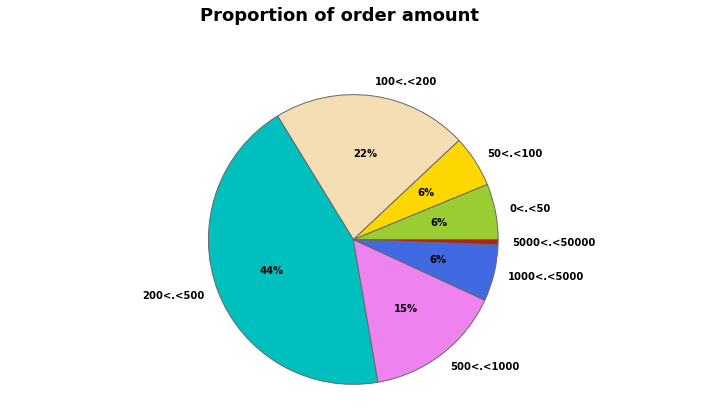

In [27]:
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0:
        continue
    val = basket_price[(basket_price['Basket Price'] < price) & (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
#______________
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [f'{price_range[i-1]}<.<{s}' for i, s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct=lambda x: f'{x:1.0f}%' if x > 1 else '', shadow=False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, 'Proportion of order amount', ha='center', fontsize=18);

It can be seen that the vast majority of orders concern relatively large purchases given that ~65% of purchases give prizes in excess of £ 200.

## 3. Insight on product categories

In the dataframe, products are uniquely identified through the `StockCode` variable. A shrort description of the products is given in the `Description` variable. In this section, I intend to use the content of this latter variable in order to group the products into different categories.

### 3.1 Products Description

As a first step, I extract from the `Description` variable the information that will prove useful. To do this, I use the following function:

In [28]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne='Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    category_keys   = []
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s):
            continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]

        for t in nouns:
            t = t.lower()
            racine = stemmer.stem(t)
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1

    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k
                    min_length = len(k)
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]

    print(f'Nb of keywords in variable {colonne}: {len(category_keys)}')
    return category_keys, keywords_roots, keywords_select, count_keywords

This function takes as input the dataframe and analyzes the content of the `Description` column by performing the following operations:

- extract the names (proper, common) appearing in the products description
- for each name, I extract the root of the word and aggregate the set of names associated with this particular root
- count the number of times each root appears in the dataframe
- when several words are listed for the same root, I consider that the keyword associated with this root is the shortest name (this systematically selects the singular when there are singular/plural variants)

The first step of the analysis is to retrieve the list of products:

In [29]:
df_products = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0: 'Description'})
display(df_products[:10])

Description
0   WHITE HANGING HEART T-LIGHT HOLDER
1                  WHITE METAL LANTERN
2       CREAM CUPID HEARTS COAT HANGER
3  KNITTED UNION FLAG HOT WATER BOTTLE
4       RED WOOLLY HOTTIE WHITE HEART.
5         SET 7 BABUSHKA NESTING BOXES
6    GLASS STAR FROSTED T-LIGHT HOLDER
7               HAND WARMER UNION JACK
8            HAND WARMER RED POLKA DOT
9        ASSORTED COLOUR BIRD ORNAMENT

Once this list is created, I use the function I previously defined in order to analyze the description of the various products:

In [30]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_products)

Nb of keywords in variable Description: 1483


The execution of this function returns three variables:
- `keywords`: the list of extracted keywords
- `keywords_roots`: a dictionary where the keys are the keywords roots and the values are the lists of words associated with those roots
- `count_keywords`: dictionary listing the number of times every word is used

At this point, I convert the `count_keywords` dictionary into a list, to sort the keywords according to their occurences:

In [31]:
list_products = []
for k, v in count_keywords.items():
    list_products.append([keywords_select[k], v])
list_products.sort(key=lambda x: x[1], reverse=True)

Using it, I create a representation of the most common keywords:

In [32]:
list_sort_products = sorted(list_products, key=lambda x: x[1], reverse=True)
#______________
num = 200
y1 = [i[1] for i in list_sort_products[:num]]

temp_list = list(itertools.accumulate(y1))
temp_sum = temp_list[-1]
y2 = [i / temp_sum for i in temp_list]

x = [i[0] for i in list_sort_products[:num]]
#______________
trace1 = go.Bar(
    x=x,
    y=y1,
    xaxis='x',
    yaxis='y1',
    name='Words Occurence'
)
trace2 = go.Scatter(
    x=x,
    y=y2,
    mode="markers+lines",
    xaxis='x',
    yaxis='y2',
    name='Words Cumulative Percentage'
)
layout = go.Layout(
    yaxis2=dict(anchor='x', overlaying='y', side='right'),
    height=1000
)
#______________
data = [trace1, trace2]
bar = go.Figure(data=data, layout=layout)
iplot(bar, validate=False)

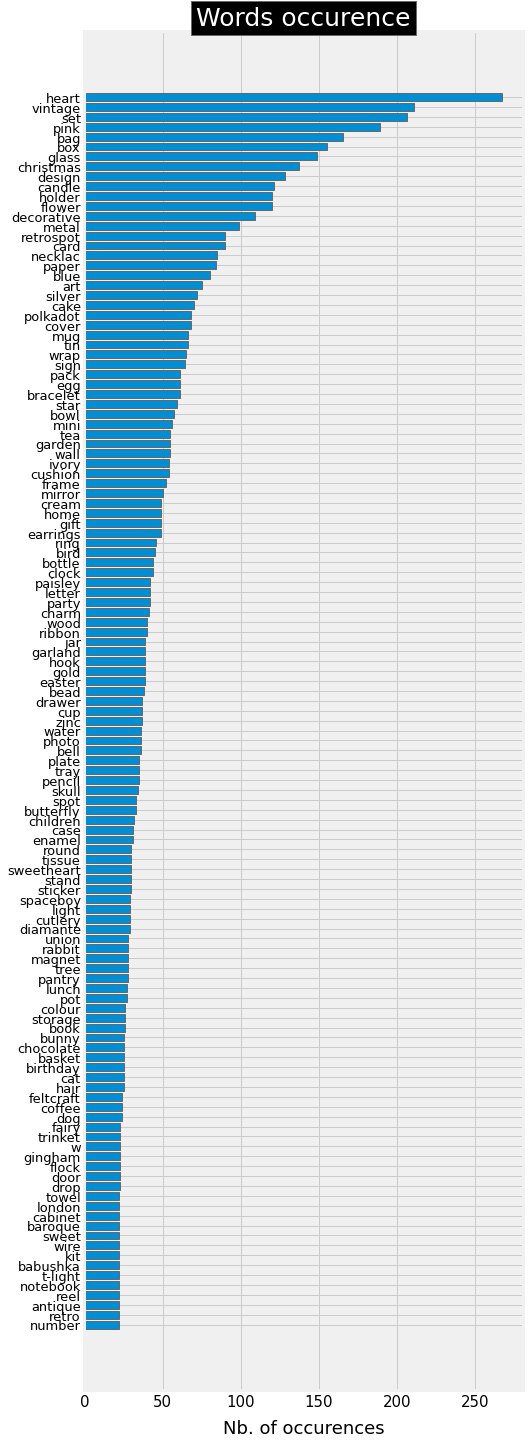

In [33]:
liste = sorted(list_products, key=lambda x: x[1], reverse=True)
#______________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k, i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize=18, labelpad=10)
ax.barh(x_axis, y_axis, align='center')
ax = plt.gca()
ax.invert_yaxis()
#______________
plt.title("Words occurence", bbox={'facecolor': 'k', 'pad': 5}, color='w',fontsize=25)
plt.show()

### 3.2 Defining product categories

The list that was obtained contains more than 1400 keywords and the most frequent ones appear in more than 200 products. However, while examinating the content of the list, I note that some names are useless. Others are do not carry information, like colors. Therefore, I discard these words from the analysis that follows and also, I decide to consider only the words that appear more than 13 times.

In [34]:
list_products = []
for k, v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']:
        continue
    if len(word) < 3 or v < 13:
        continue
    if ('+' in word) or ('/' in word):
        continue
    list_products.append([word, v])
#______________
list_products.sort(key=lambda x: x[1], reverse=True)
print('Keyword:', len(list_products))

Keyword: 193


#### 3.2.1 Data encoding

Now I will use these keywords to create groups of product. Firstly, I define the $X$ matrix as:

|   | word 1  |  ...  | word j  | ...  | word N  |
|:-:|---|---|---|---|---|
| product 1  | $a_{1,1}$  |     |   |   | $a_{1,N}$  |
| ...        |            |     | ...  |   |   |
|product i   |    ...     |     | $a_{i,j}$    |   | ...  |
|...         |            |     |  ... |   |   |
| product M  | $a_{M,1}$  |     |   |   | $a_{M,N}$   |

where the $a_ {i, j}$ coefficient  is 1 if the description of the product $i$ contains the word $j$, and 0 otherwise.

In [35]:
df_list_products = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x: int(key.upper() in x), df_list_products))

The $X$ matrix indicates the words contained in the description of the products using the *one-hot-encoding* principle. In practice, I have found that introducing the price range results in more balanced groups in terms of element numbers.
Hence, I add 6 extra columns to this matrix, where I indicate the price range of the products:

In [36]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold) - 1:
        col = f'.>{threshold[i]}'
    else:
        col = f'{threshold[i]}<.<{threshold[i+1]}'
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(df_list_products):
    price = df_cleaned[df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while price > threshold[j]:
        j += 1
        if j == len(threshold):
            break
    X.loc[i, label_col[j-1]] = 1

and to choose the appropriate ranges, I check the number of products in the different groups:

In [37]:
print("{:<8} {:<20} \n".format('gamme', 'nb. produits') + 20 * '-')
for i in range(len(threshold)):
    if i == len(threshold) - 1:
        col = f'.>{threshold[i]}'
    else:
        col = f'{threshold[i]}<.<{threshold[i+1]}'
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

gamme    nb. produits         
--------------------
0<.<1       964                 
1<.<2       1009                
2<.<3       673                 
3<.<5       606                 
5<.<10      470                 
.>10        156                 


#### 3.2.2 Creating clusters of products

In this section, I will group the products into different classes. In the case of matrices with binary encoding, the most suitable metric for the calculation of distances is the [Hamming's metric](https://en.wikipedia.org/wiki/Distance_de_Hamming). Note that the **kmeans** method of sklearn uses a Euclidean distance that can be used, but it is not to the best choice in the case of categorical variables. However, in order to use the Hamming's metric, we need to use the [kmodes](https://pypi.python.org/pypi/kmodes/) package which is not available on the current plateform. Hence, I use the **kmeans** method even if this is not the best choice.

In order to define (approximately) the number of clusters that best represents the data, I use the silhouette score:

In [38]:
matrix = X.to_numpy()
for n_clusters in range(3, 15):
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print(f'For n_clusters = {n_clusters}, The average silhouette_score is : {silhouette_avg:.4f}')

For n_clusters = 3, The average silhouette_score is : 0.1007
For n_clusters = 4, The average silhouette_score is : 0.1261
For n_clusters = 5, The average silhouette_score is : 0.1466
For n_clusters = 6, The average silhouette_score is : 0.1452
For n_clusters = 7, The average silhouette_score is : 0.1578
For n_clusters = 8, The average silhouette_score is : 0.1508
For n_clusters = 9, The average silhouette_score is : 0.1586
For n_clusters = 10, The average silhouette_score is : 0.1388
For n_clusters = 11, The average silhouette_score is : 0.1421
For n_clusters = 12, The average silhouette_score is : 0.1286
For n_clusters = 13, The average silhouette_score is : 0.1371
For n_clusters = 14, The average silhouette_score is : 0.1241


In practice, the scores obtained above can be considered equivalent since, depending on the run, scores of $ 0.1 \pm 0.05 $ will be obtained for all clusters with `n_clusters` $> $ 3 (we obtain slightly lower scores for the first cluster). On the other hand, I found that beyond 5 clusters, some clusters contained very few elements. I therefore choose to separate the dataset into 5 clusters. In order to ensure a good classification at every run of the notebook, I iterate untill we obtain the best possible silhouette score, which is, in the present case, around 0.15:

In [39]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)

    #km = kmodes.KModes(n_clusters=n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print(f'For n_clusters = {n_clusters}, The average silhouette_score is : {silhouette_avg:.4f}')

For n_clusters = 5, The average silhouette_score is : 0.1452


#### 3.2.3  Characterizing the content of clusters

I check the number of elements in every class:

In [40]:
pd.Series(clusters).value_counts()

4    1159
3     964
0     673
1     606
2     476
dtype: int64


`A. Silhouette intra-cluster score`

In order to have an insight on the quality of the classification, we can represent the silhouette scores of each element of the different clusters. This is the purpose of the next figure which is taken from the [sklearn documentation](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html):

In [41]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #______________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #______________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #______________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color='red', fontweight='bold', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

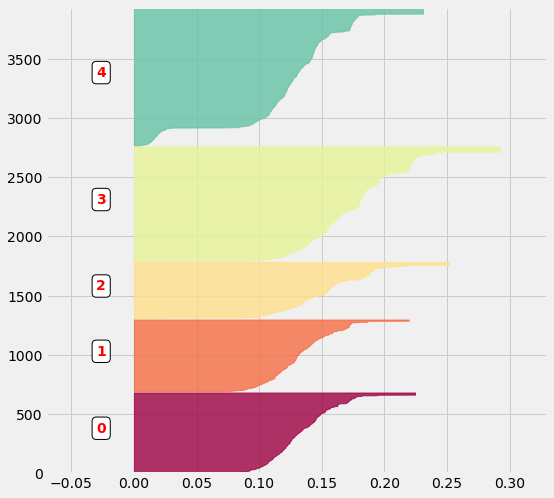

In [42]:
#______________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)
#______________
# and do the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

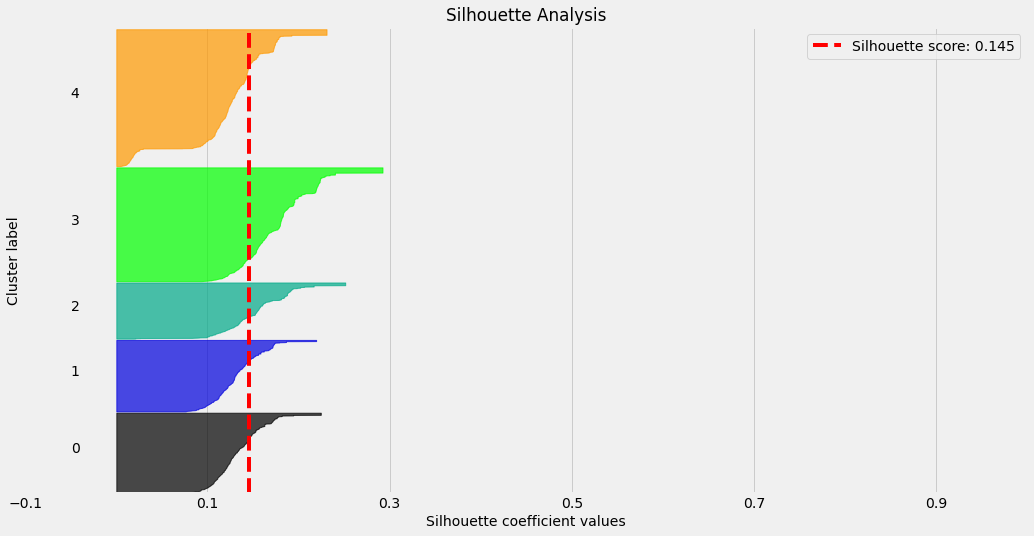

In [43]:
skplt.metrics.plot_silhouette(matrix, clusters, figsize=(16, 8))
plt.show()

`B. Word Cloud`

Now we can have a look at the type of objects that each cluster represents. In order to obtain a global view of their contents, I determine which keywords are the most frequent in each of them

In [44]:
df_products = pd.DataFrame(df_list_products)
list_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    list_cluster = df_products.loc[clusters == i]
    for word in list_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']:
            continue
        occurence[i][word] = sum(list_cluster.loc[:, 0].str.contains(word.upper()))

and I output the result as wordclouds:

In [45]:
def random_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return f'hsl({h}, {s}%, {l}%)'
#______________
def make_wordcloud(list_words, increment):
    ax1 = fig.add_subplot(4, 2, increment)
    words = dict()
    trunc_occurences = list_words[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    #______________
    wordcloud = WordCloud(width=1000, height=400, background_color='lightgrey', max_words=1628, relative_scaling=1, color_func=random_color_func, normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title(f'cluster n{increment-1}')


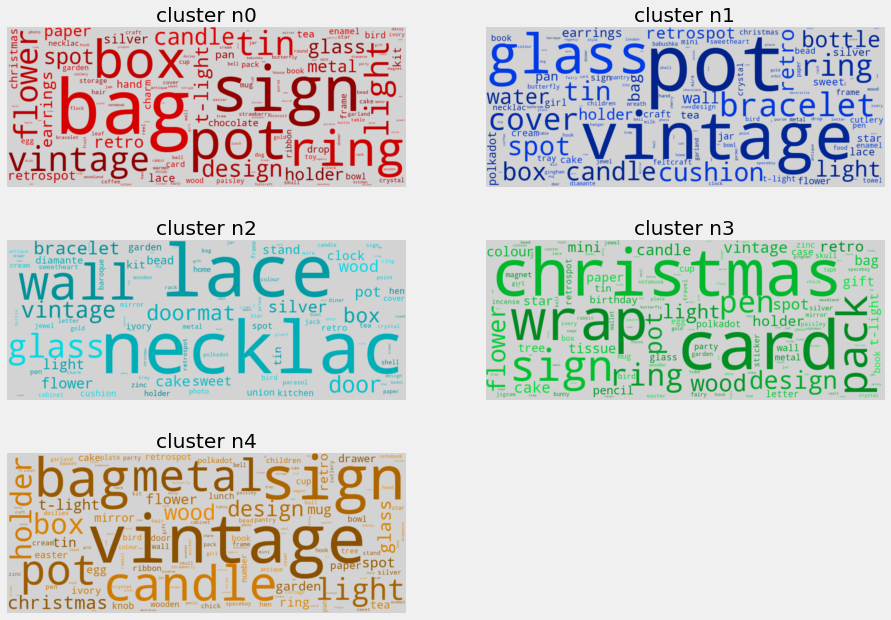

In [46]:
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    list_words = []
    for key, value in list_cluster_occurences.items():
        list_words.append([key, value])
    list_words.sort(key=lambda x: x[1], reverse=True)
    make_wordcloud(list_words, i+1)

From this representation, we can see that for example, one of the clusters contains objects that could be associated with gifts (keywords: Christmas, packaging, card, ...). Another cluster would rather contain luxury items and jewelry (keywords: necklace, bracelet, lace, silver, ...). Nevertheless, it can also be observed that many words appear in various clusters and it is therefore difficult to clearly distinguish them.


`C. Principal Component Analysis`

In order to ensure that these clusters are truly distinct, I look at their composition. Given the large number of variables of the initial matrix, I first perform a PCA:

In [47]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

and then check for the amount of variance explained by each component:

In [48]:
#______________
y1 = pca.explained_variance_ratio_
y2 = pca.explained_variance_ratio_.cumsum()
x = np.arange(1, matrix.shape[1]+1)
#______________
trace1 = go.Bar(
    x=x,
    y=y1,
    xaxis='x',
    yaxis='y1',
    name='Individual Explained Variance'
)
trace2 = go.Scatter(
    x=x,
    y=y2,
    mode="markers+lines",
    xaxis='x',
    yaxis='y2',
    name='Cumulative Explained Variance'
)
layout = go.Layout(
    xaxis=dict(title='Principal components'),
    yaxis1=dict(title='Explained variance'),
    yaxis2=dict(anchor='x', overlaying='y', side='right'),
    height=1000
)
#______________
data = [trace1, trace2]
bar = go.Figure(data=data, layout=layout)
iplot(bar, validate=False)

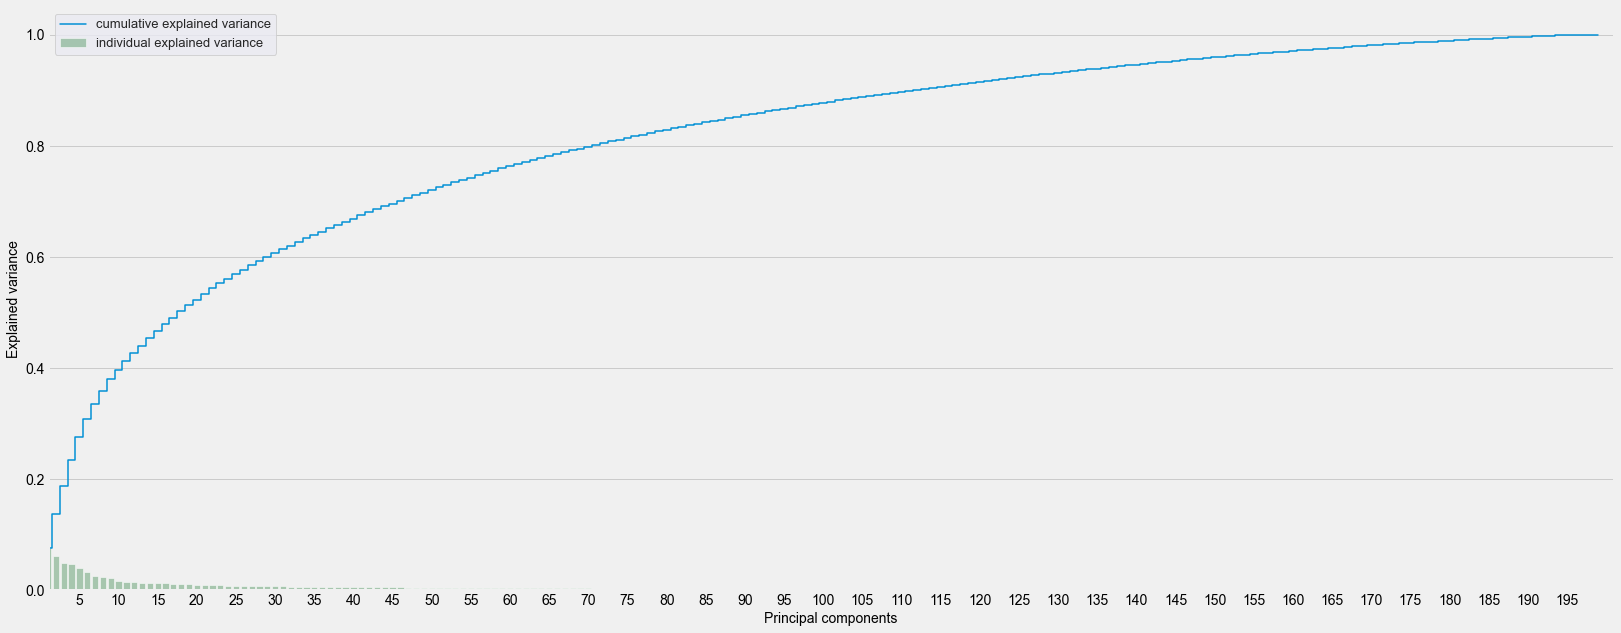

In [49]:
fig, ax = plt.subplots(figsize=(25, 10))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid', label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color='g', label='individual explained variance')
plt.xlim(0, 200)

ax.set_xticklabels([s if int(s.get_text())%5 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

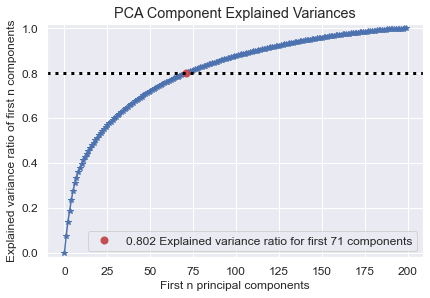

In [50]:
skplt.decomposition.plot_pca_component_variance(pca, target_explained_variance=0.8)
plt.show()

We see that the number of components required to explain the data is extremely important: we need more than 100 components to explain 90% of the variance of the data. In practice, I decide to keep only a limited number of components since this decomposition is only performed to visualize the data:

In [51]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

In [52]:
mat

0         1         2         3         4         5         6  \
0     0.040414  0.497231  0.088611  1.585315 -0.341041 -0.165407  0.682011   
1    -0.018280  0.422522  0.560011 -0.433861 -0.344755 -0.180220 -0.252114   
2     0.015637  0.315746  1.247460  0.749127 -0.505731 -0.011968 -0.163388   
3    -0.035557  0.467762  0.633837 -0.475282 -0.348002 -0.157559 -0.188337   
4     0.008751  0.319166  1.232739  0.739154 -0.492977 -0.010321 -0.144176   
...        ...       ...       ...       ...       ...       ...       ...   
3873 -0.728051 -0.428816 -0.118999 -0.108652 -0.051219 -0.111352 -0.098307   
3874 -0.728051 -0.428816 -0.118999 -0.108652 -0.051219 -0.111352 -0.098307   
3875 -0.700205 -0.433659 -0.121735 -0.080147 -0.025276 -0.079414 -0.050126   
3876  0.046496  0.508855  0.111889  1.600005 -0.339973 -0.166174  0.670586   
3877 -0.036313  0.633804 -0.604744  0.237357 -0.136734 -0.140085  0.003375   

             7         8         9  ...        41        42        43  \
0     1.027706  0.750753  0.222363  ...  0.045514  0.054073 -0.044043   
1    -0.004596  0.149651 -0.088401  ...  0.034757  0.024166  0.000490   
2    -0.125534 -0.027523 -0.016176  ... -0.153241  0.192852  0.015051   
3     0.065617 -0.049691 -0.043384  ... -0.139231  0.045126  0.091962   
4    -0.115462 -0.008468  0.004281  ... -0.000683  0.061640 -0.064624   
...        ...       ...       ...  ...       ...       ...       ...   
3873  0.094886 -0.197472 -0.217606  ... -0.180339 -0.029537  0.141965   
3874  0.094886 -0.197472 -0.217606  ... -0.180339 -0.029537  0.141965   
3875  0.034318 -0.092649 -0.054367  ...  0.349289  0.036189 -0.336425   
3876  1.026061  0.741948  0.236239  ...  0.026353  0.026102  0.030653   
3877  0.044576 -0.148804 -0.086073  ...  0.234830 -0.108481  0.115638   

            44        45        46        47        48        49  cluster  
0    -0.162652 -0.016092  0.065278  0.055991  0.000436  0.076765        0  
1    -0.002050  0.021759  0.041937  0.011633  0.043199  0.031628        1  
2    -0.401708  0.045402  0.105857 -0.147832 -0.321911  0.267889        1  
3    -0.093649 -0.149373 -0.254776  0.770706  0.080337 -0.405784        1  
4    -0.055824 -0.045644  0.057311 -0.024159 -0.015328 -0.024523        1  
...        ...       ...       ...       ...       ...       ...      ...  
3873  0.006783 -0.031057 -0.099570  0.050970 -0.023992  0.027046        3  
3874  0.006783 -0.031057 -0.099570  0.050970 -0.023992  0.027046        3  
3875 -0.018160  0.125446 -0.117581 -0.055190 -0.040799  0.093762        3  
3876 -0.193999  0.034068  0.079749 -0.178017 -0.210588  0.164696        0  
3877 -0.199039 -0.126512 -0.253260 -0.360817  0.280562  0.123930        0  

[3878 rows x 51 columns]

In [53]:
LABEL_COLOR_MAP = {0: 'r', 1: 'gold', 2: 'b', 3: 'k', 4: 'c', 5: 'g'}
color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}
#______________
fig = px.scatter_matrix(
    mat,
    labels=labels,
    dimensions=range(5),
    color=color,
    height=1000
)
fig.update_traces(diagonal_visible=False)
fig.show()

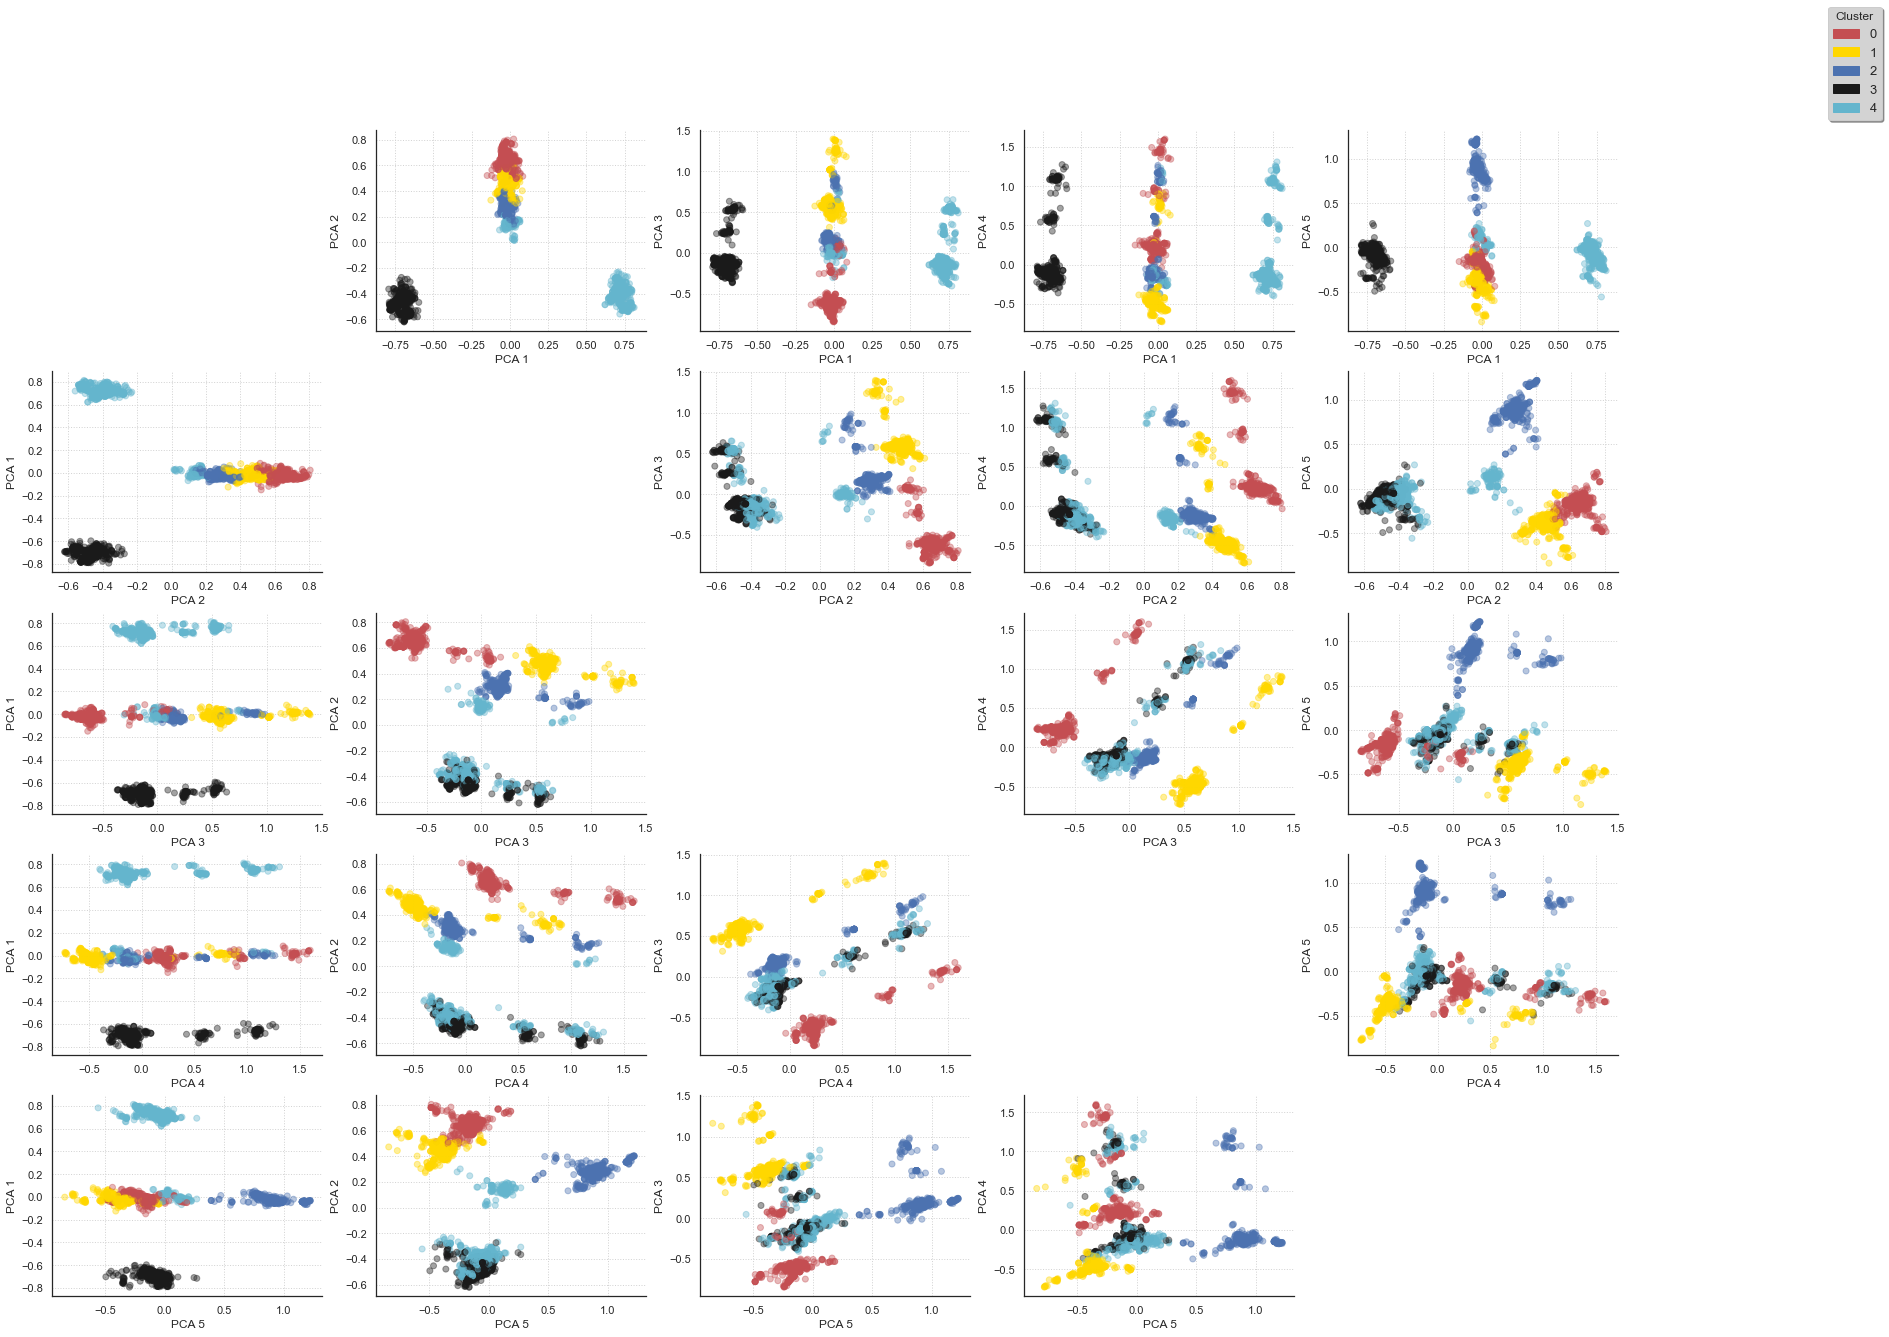

In [54]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize=(25,20))
increment = 0
for ix in range(5):
    for iy in range(5):
        increment += 1
        if ix == iy:
            continue
        ax = fig.add_subplot(5, 5, increment)
        ax.scatter(mat[ix], mat[iy], c=label_color, alpha=0.4)
        plt.ylabel(f'PCA {iy+1}', fontsize=12)
        plt.xlabel(f'PCA {ix+1}', fontsize=12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
#______________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color=LABEL_COLOR_MAP[i], label=i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), title='Cluster', facecolor='lightgrey', shadow=True, frameon=True, framealpha=1, fontsize=13, bbox_transform=plt.gcf().transFigure)

plt.show()

## 4. Customer categories

### 4.1 Formatting data

In the previous section, the different products were grouped in five clusters. In order to prepare the rest of the analysis, a first step consists in introducing this information into the dataframe. To do this, I create the categorical variable `categ_product` where I indicate the cluster of each product :

In [55]:
corresp = dict()
for key, val in zip(df_list_products, clusters):
    corresp[key] = val
#______________
df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)

#### 4.1.1 Grouping products

In a second step, I decide to create the `categ_N` variables (with $ N \in [0: 4]$) that contains the amount spent in each product category:

In [56]:
for i in range(5):
    col = 'categ_{}'.format(i)
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x: x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace=True)
#______________
display(df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:10])

InvoiceNo                          Description  categ_product  categ_0  \
0    536365   WHITE HANGING HEART T-LIGHT HOLDER              0     15.3   
1    536365                  WHITE METAL LANTERN              1      0.0   
2    536365       CREAM CUPID HEARTS COAT HANGER              1      0.0   
3    536365  KNITTED UNION FLAG HOT WATER BOTTLE              1      0.0   
4    536365       RED WOOLLY HOTTIE WHITE HEART.              1      0.0   
5    536365         SET 7 BABUSHKA NESTING BOXES              2      0.0   
6    536365    GLASS STAR FROSTED T-LIGHT HOLDER              1      0.0   
7    536366               HAND WARMER UNION JACK              0     11.1   
8    536366            HAND WARMER RED POLKA DOT              4      0.0   
9    536367        ASSORTED COLOUR BIRD ORNAMENT              4      0.0   

   categ_1  categ_2  categ_3  categ_4  
0     0.00      0.0      0.0     0.00  
1    20.34      0.0      0.0     0.00  
2    22.00      0.0      0.0     0.00  
3    20.34      0.0      0.0     0.00  
4    20.34      0.0      0.0     0.00  
5     0.00     15.3      0.0     0.00  
6    25.50      0.0      0.0     0.00  
7     0.00      0.0      0.0     0.00  
8     0.00      0.0      0.0    11.10  
9     0.00      0.0      0.0    54.08

Up to now, the information related to a single order was split over several lines of the dataframe (one line per product). I decide to collect the information related to a particular order and put in in a single entry. I therefore create a new dataframe that contains, for each order, the amount of the basket, as well as the way it is distributed over the 5 categories of products:

In [57]:
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice': 'Basket Price'})
#______________
for i in range(5):
    col = f'categ_{i}'
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp[col]
#______________
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis=1, inplace=True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________
basket_price = basket_price[basket_price['Basket Price'] > 0]
display(basket_price.sort_values('CustomerID', ascending=True)[:10])

CustomerID InvoiceNo  Basket Price  categ_0  categ_1  categ_2  categ_3  \
1       12347    537626        711.79    83.40   293.35   124.44    23.40   
2       12347    542237        475.39    53.10   169.20     0.00    84.34   
3       12347    549222        636.25    71.10   115.00     0.00    81.00   
4       12347    556201        382.52    78.06   168.76    19.90    41.40   
5       12347    562032        584.91   119.70   158.16    97.80    61.30   
6       12347    573511       1294.32   435.90   368.72    55.60   154.30   
7       12347    581180        224.82    55.44     0.00    30.00    38.58   
8       12348    539318        892.80     0.00     0.00     0.00   478.80   
9       12348    541998        227.44     0.00     0.00     0.00   187.44   
10      12348    548955        367.00     0.00     0.00     0.00    17.00   

    categ_4                   InvoiceDate  
1    187.20 2010-12-07 14:57:00.000001024  
2    168.75 2011-01-26 14:29:59.999999744  
3    369.15 2011-04-07 10:42:59.999999232  
4     74.40 2011-06-09 13:01:00.000000256  
5    147.95 2011-08-02 08:48:00.000000000  
6    279.80 2011-10-31 12:25:00.000001280  
7    100.80 2011-12-07 15:52:00.000000000  
8    414.00 2010-12-16 19:09:00.000000000  
9     40.00 2011-01-25 10:42:00.000000000  
10   350.00 2011-04-05 10:47:00.000000000

#### 4.1.2 Separation of data over time

The dataframe `basket_price` contains information for a period of 12 months. Later, one of the objectives will be to develop a model capable of characterizing and anticipating the habits of the customers visiting the site and this, from their first visit. In order to be able to test the model in a realistic way, I split the data set by retaining the first 10 months to develop the model and the following two months to test it:

In [58]:
print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())

2010-12-01 08:26:00 -> 2011-12-09 12:50:00


In [59]:
set_entrainement = basket_price[basket_price['InvoiceDate'] < datetime.date(2011, 10, 1).strftime("%Y-%d-%m")]
set_test         = basket_price[basket_price['InvoiceDate'] >= datetime.date(2011, 10, 1).strftime("%Y-%d-%m")]
basket_price     = set_entrainement.copy(deep=True)

#### 4.1.3 Consumer Order Combinations

In a second step, I group together the different entries that correspond to the same user. I thus determine the number of purchases made by the user, as well as the minimum, maximum, average amounts and the total amount spent during all the visits:

In [60]:
transactions_per_user = basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count', 'min', 'max', 'mean', 'sum'])
for i in range(5):
    col = f'categ_{i}'
    transactions_per_user.loc[:, col] = basket_price.groupby(by=['CustomerID'])[col].sum() / transactions_per_user['sum']*100
#______________
transactions_per_user.reset_index(drop=False, inplace=True)
display(transactions_per_user.sort_values('CustomerID', ascending=True)[:10])

CustomerID  count      min      max      mean      sum    categ_0  \
0      12347      1   711.79   711.79   711.790   711.79  11.716939   
1      12348      1   892.80   892.80   892.800   892.80   0.000000   
2      12370      2   277.20  1587.07   932.135  1864.27  30.875356   
3      12377      1  1001.52  1001.52  1001.520  1001.52  21.926671   
4      12383      1   600.72   600.72   600.720   600.72   2.946464   
5      12386      2   143.00   258.90   200.950   401.90   4.404081   
6      12395      2   330.87   346.10   338.485   676.97  15.517674   
7      12413      1   415.30   415.30   415.300   415.30  23.489044   
8      12415      1  7011.38  7011.38  7011.380  7011.38  13.502335   
9      12417      1   259.39   259.39   259.390   259.39  13.551024   

     categ_1    categ_2    categ_3    categ_4  
0  41.212998  17.482684   3.287486  26.299892  
1   0.000000   0.000000  53.629032  46.370968  
2  13.029229   6.696991   9.317320  40.081104  
3  35.526000   0.000000   9.837048  32.710280  
4   7.890531   0.000000  46.214543  42.948462  
5   0.000000  24.483702  27.668574  43.443643  
6   0.000000   4.697402  48.749575  31.035349  
7  10.763304  36.094390  17.673971  11.979292  
8  31.038112   3.850882  11.559493  40.049177  
9  19.314546  13.955819   0.000000  53.178611

Finally, I define two additional variables that give the number of days elapsed since the first purchase `FirstPurchase` and the number of days since the last purchase `LastPurchase`:

In [61]:
last_date = basket_price['InvoiceDate'].max().date()
#______________
first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())
#______________
test  = first_registration.applymap(lambda x: (last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x: (last_date - x.date()).days)
#______________
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop=False)['InvoiceDate']
transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop=False)['InvoiceDate']
#______________
display(transactions_per_user[:10])

CustomerID  count      min      max      mean      sum    categ_0  \
0      12347      1   711.79   711.79   711.790   711.79  11.716939   
1      12348      1   892.80   892.80   892.800   892.80   0.000000   
2      12370      2   277.20  1587.07   932.135  1864.27  30.875356   
3      12377      1  1001.52  1001.52  1001.520  1001.52  21.926671   
4      12383      1   600.72   600.72   600.720   600.72   2.946464   
5      12386      2   143.00   258.90   200.950   401.90   4.404081   
6      12395      2   330.87   346.10   338.485   676.97  15.517674   
7      12413      1   415.30   415.30   415.300   415.30  23.489044   
8      12415      1  7011.38  7011.38  7011.380  7011.38  13.502335   
9      12417      1   259.39   259.39   259.390   259.39  13.551024   

     categ_1    categ_2    categ_3    categ_4  FirstPurchase  LastPurchase  
0  41.212998  17.482684   3.287486  26.299892             33            33  
1   0.000000   0.000000  53.629032  46.370968             24            24  
2  13.029229   6.696991   9.317320  40.081104             26            23  
3  35.526000   0.000000   9.837048  32.710280             20            20  
4   7.890531   0.000000  46.214543  42.948462             18            18  
5   0.000000  24.483702  27.668574  43.443643             32             3  
6   0.000000   4.697402  48.749575  31.035349             37            23  
7  10.763304  36.094390  17.673971  11.979292              3             3  
8  31.038112   3.850882  11.559493  40.049177              3             3  
9  19.314546  13.955819   0.000000  53.178611             23            23

A customer category of particular interest is that of customers who make only one purchase. One of the objectives may be, for example, to target these customers in order to retain them. In part, I find that this type of customer represents ~2/3 of the customers listed:

In [62]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print(f'nb. of clients buy unique product: {n1:<2}/{n2:<5} ({n1/n2*100:<2.2f}%)')

nb. of clients buy unique product: 660/975   (67.69%)


### 4.2 Creation of customers categories

#### 4.2.1 Data encoding

The dataframe `transactions_per_user` contains a summary of all the commands that were made. Each entry in this dataframe corresponds to a particular client. I use this information to characterize the different types of customers and only keep a subset of variables:

In [63]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#______________
selected_customers = transactions_per_user.copy(deep=True)
matrix = selected_customers[list_cols].to_numpy()

In practice, the different variables I selected have quite different ranges of variation and before continuing the analysis, I  create a matrix where these data are standardized:

In [64]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  1.65846154 305.99072821 467.54452308 377.42556622  22.67395717
  19.5137947   15.46670044  11.86632561  30.51877387]


In the following, I will create clusters of customers. In practice, before creating these clusters, it is interesting to define a base of smaller dimension allowing to describe the `scaled_matrix` matrix. In this case, I will use this base in order to create a representation of the different clusters and thus verify the quality of the separation of the different groups. I therefore perform a PCA beforehand:

In [65]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

and I represent the amount of variance explained by each of the components:

In [66]:
list_sort_products = sorted(list_products, key=lambda x: x[1], reverse=True)
#______________
y1 = pca.explained_variance_ratio_
y2 = pca.explained_variance_ratio_.cumsum()
x = np.arange(1,matrix.shape[1]+1)
#______________
trace1 = go.Bar(
    x=x,
    y=y1,
    xaxis='x',
    yaxis='y1',
    name='Individual Explained Variance'
)
trace2 = go.Scatter(
    x=x,
    y=y2,
    mode="markers+lines",
    xaxis='x',
    yaxis='y2',
    name='Cumulative Explained Variance'
)
layout = go.Layout(
    xaxis=dict(title='Principal components'),
    yaxis1=dict(title='Explained variance'),
    yaxis2=dict(anchor='x', overlaying='y', side='right'),
    height=1000
)
#______________
data = [trace1, trace2]
bar = go.Figure(data=data, layout=layout)
iplot(bar, validate=False)

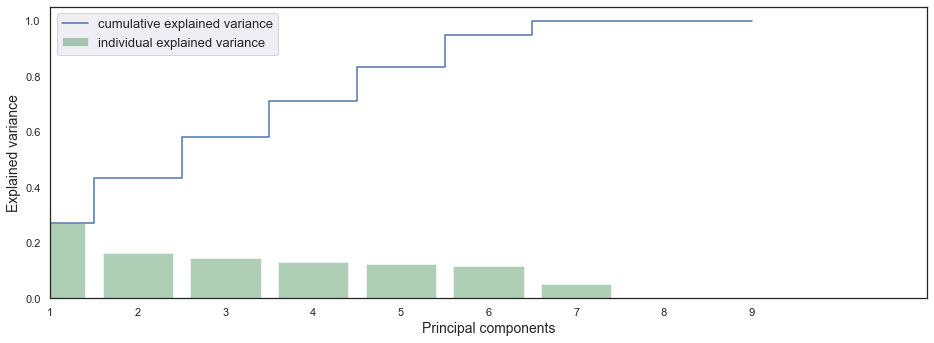

In [67]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid', label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color='g', label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%1 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize=14)
plt.xlabel('Principal components', fontsize=14)
plt.legend(loc='best', fontsize=13);

#### 4.2.2 Creation of customer categories

At this point, I define clusters of clients from the standardized matrix that was defined earlier and using the `k-means` algorithm from` scikit-learn`.

In [68]:
for n_clusters in range(3,15):
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=30)
    kmeans.fit(scaled_matrix)
    clusters = kmeans.predict(scaled_matrix)
    silhouette_avg = silhouette_score(scaled_matrix, clusters)
    print(f'For n_clusters = {n_clusters} The average silhouette_score is : {silhouette_avg:4f}')

For n_clusters = 3 The average silhouette_score is : 0.144416
For n_clusters = 4 The average silhouette_score is : 0.156821
For n_clusters = 5 The average silhouette_score is : 0.176794
For n_clusters = 6 The average silhouette_score is : 0.183760
For n_clusters = 7 The average silhouette_score is : 0.206246
For n_clusters = 8 The average silhouette_score is : 0.213454
For n_clusters = 9 The average silhouette_score is : 0.204105
For n_clusters = 10 The average silhouette_score is : 0.204733
For n_clusters = 11 The average silhouette_score is : 0.212455
For n_clusters = 12 The average silhouette_score is : 0.215177
For n_clusters = 13 The average silhouette_score is : 0.216949
For n_clusters = 14 The average silhouette_score is : 0.200140


 I choose the number of clusters based on the silhouette score and I find that the best score is obtained with 11 clusters:

In [69]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('score de silhouette: {:<.4f}'.format(silhouette_avg))

score de silhouette: 0.2132


At first, I look at the number of customers in each cluster:

In [70]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['nb. clients']).T

6    0    1   3   10  2   4   9   5   7   8 
nb. clients  363  153  145  87  85  78  40  19   2   2   1

`A. Report via the PCA`

There is a certain disparity in the sizes of different groups that have been created. Hence I will now try to understand the content of these clusters in order to validate (or not) this particular separation. At first, I use the result of the PCA:

In [71]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

in order to create a representation of the various clusters:

In [72]:
LABEL_COLOR_MAP = {0: 'r', 1: 'tan', 2: 'b', 3: 'k', 4: 'c', 5: 'g', 6: 'deeppink', 7: 'skyblue', 8: 'darkcyan', 9: 'orange', 10: 'yellow', 11: 'tomato', 12: 'seagreen'}
color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}
#______________
fig = px.scatter_matrix(
    mat,
    labels=labels,
    dimensions=range(6),
    color=color,
    height=1000
)
fig.update_traces(diagonal_visible=False)
fig.show()

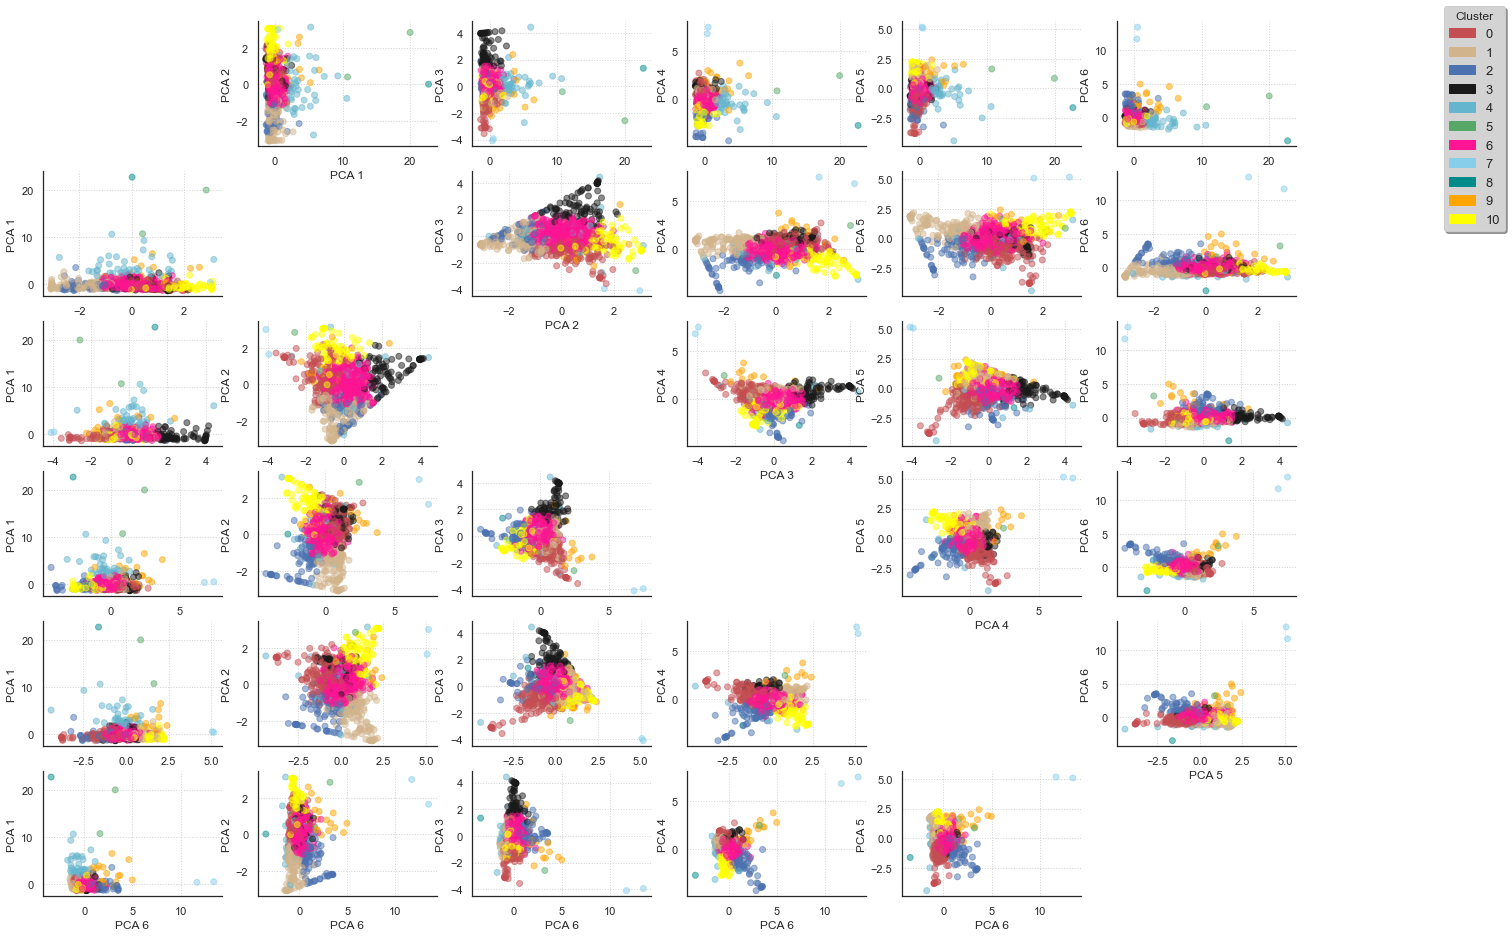

In [73]:
import matplotlib.patches as mpatches

sns.set_style('white')
sns.set_context('notebook', font_scale=1, rc={'lines.linewidth': 2.5})

LABEL_COLOR_MAP = {0: 'r', 1: 'tan', 2: 'b', 3: 'k', 4: 'c', 5: 'g', 6: 'deeppink', 7: 'skyblue', 8: 'darkcyan', 9: 'orange', 10: 'yellow', 11: 'tomato', 12: 'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize=(20,15))
increment = 0
for ix in range(6):
    for iy in range(6):
        increment += 1
        if ix == iy:
            continue
        ax = fig.add_subplot(6, 6, increment)
        ax.scatter(mat[ix], mat[iy], c=label_color, alpha=0.5)
        plt.ylabel(f'PCA {iy+1}', fontsize=12)
        plt.xlabel(f'PCA {ix+1}', fontsize=12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
#______________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color=LABEL_COLOR_MAP[i], label=i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), title='Cluster', facecolor='lightgrey',shadow=True, frameon=True, framealpha=1, fontsize=13, bbox_transform=plt.gcf().transFigure)

plt.tight_layout()

From this representation, it can be seen, for example, that the first principal component allow to separate the tiniest clusters from the rest. More generally, we see that there is always a representation in which two clusters will appear to be distinct.

`B. Score de silhouette intra-cluster`

As with product categories, another way to look at the quality of the separation is to look at silouhette scores within different clusters:

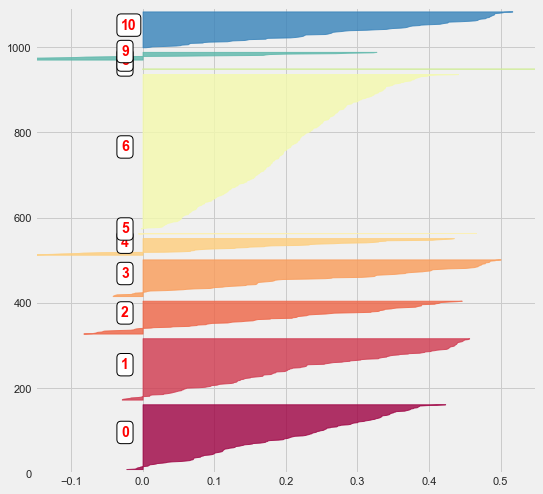

In [74]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#______________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#______________
# and do the graph
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

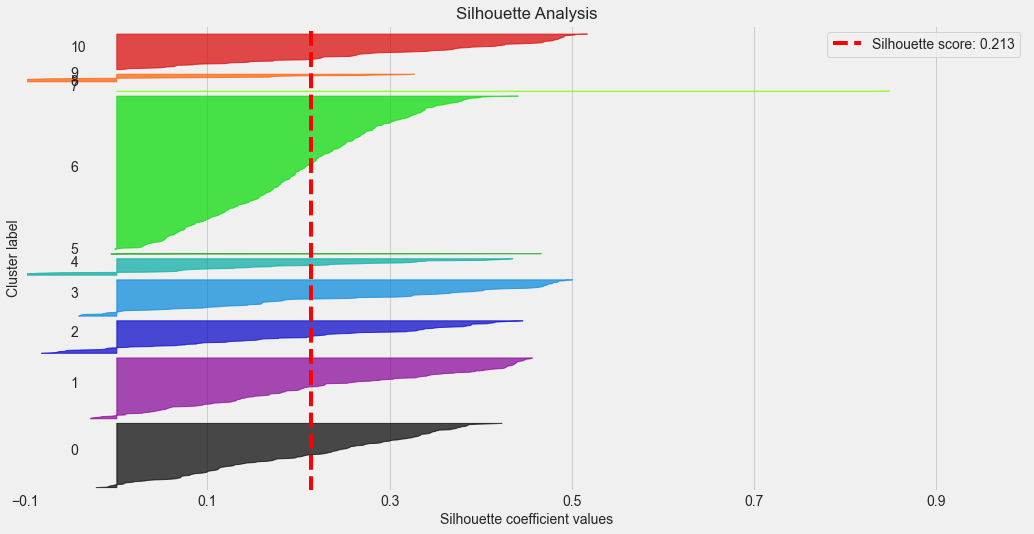

In [75]:
skplt.metrics.plot_silhouette(scaled_matrix, clusters_clients, figsize=(16, 8))
plt.show()

`C. Customers morphotype`

At this stage, I have verified that the different clusters are indeed disjoint (at least, in a global way). It remains to understand the habits of the customers in each cluster. To do so, I start by adding to the `selected_customers` dataframe a variable that defines the cluster to which each client belongs:

In [76]:
selected_customers.loc[:, 'cluster'] = clusters_clients

Then, I average the contents of this dataframe by first selecting the different groups of clients. This gives access to, for example, the average baskets price, the number of visits or the total sums spent by the clients of the different clusters. I also determine the number of clients in each group (variable `size`):

In [77]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop=True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#______________
merged_df.drop('CustomerID', axis=1, inplace=True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')
display(merged_df[:10])

number of customers: 975


count         min         max        mean         sum    categ_0  \
cluster                                                                        
2.0      1.294872  247.329231  293.144231  268.672894  341.074359  11.938246   
10.0     1.341176  223.135647  294.310941  255.365735  367.811765  12.279267   

           categ_1   categ_2   categ_3    categ_4  FirstPurchase  \
cluster                                                            
2.0       6.159441  7.313444  51.03503  23.553839      27.461538   
10.0     63.868088  8.178803   3.85662  11.887803      28.552941   

         LastPurchase  size  
cluster                      
2.0         24.923077    78  
10.0        25.517647    85

Finally, I re-organize the content of the dataframe by ordering the different clusters: first, in relation to the amount wpsent in each product category and then, according to the total amount spent:

In [78]:
list_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    list_index.append(merged_df[merged_df[column] > 30].index.values[0])
#___________________________________
list_index_reordered = list_index
list_index_reordered += [ s for s in merged_df.index if s not in list_index]
#___________________________________________________________
merged_df = merged_df.reindex(index = list_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])

cluster      count          min           max         mean           sum  \
0       3.0   1.379310   237.836092    354.449770   290.164511    407.550575   
1      10.0   1.341176   223.135647    294.310941   255.365735    367.811765   
2       0.0   1.509804   237.875425    305.129935   271.024404    413.197059   
3       2.0   1.294872   247.329231    293.144231   268.672894    341.074359   
4       1.0   1.393103   231.122069    327.224966   277.088802    407.192345   
5       6.0   1.581267   284.722424    386.562424   333.629036    531.913361   
6       4.0   1.500000  1397.744750   1654.585000  1523.768375   2321.680250   
7       7.0  35.500000    11.575000    559.250000   137.457464   4851.095000   
8       9.0   7.210526   143.057368   2313.828947   938.919408   5941.504211   
9       8.0   1.000000  7011.380000   7011.380000  7011.380000   7011.380000   
10      5.0   3.000000   233.360000  12203.205000  5627.296250  18213.245000   

      categ_0    categ_1    categ_2    categ_3    categ_4  size  
0   67.875769   7.517624   5.624538   3.550199  15.431871    87  
1   12.279267  63.868088   8.178803   3.856620  11.887803    85  
2   13.810879  15.001934  43.821862   6.438365  21.032210   153  
3   11.938246   6.159441   7.313444  51.035030  23.553839    78  
4   11.277046   7.977691   8.025175   6.602987  66.117102   145  
5   25.090216  21.195925  12.367218  11.989573  29.402413   363  
6   20.567024  18.444290  15.217893  12.115193  33.655600    40  
7   20.074418  22.805837  20.705808   8.093096  28.320841     2  
8   25.246579  23.090191  14.018992   7.181506  30.462732    19  
9   13.502335  31.038112   3.850882  11.559493  40.049177     1  
10   7.496904  31.687912  23.508436   4.367612  32.939136     2

Finally, I created a representation of the different morphotypes. To do this, I define a class to create "Radar Charts" (which has been adapted from this [kernel](https://www.kaggle.com/yassineghouzam/don-t-know-why-employees-leave)):

In [79]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:]
        size_x, size_y = sizes[:]

        axes = [fig.add_axes([ix, iy, size_x, size_y], polar=True, label=f'axes{i}') for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels=variables)

        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)

        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")

        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], num=n_ordinate_levels)
            grid_label = ['']+['{:.0f}'.format(x) for x in grid[1:-1]]
            # ax.set_rgrids(grid, labels=grid_label, angle=angles[i])
            ax.set_ylim(*ranges[i])

        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]

    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)

    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)


This allows to have a global view of the content of each cluster:

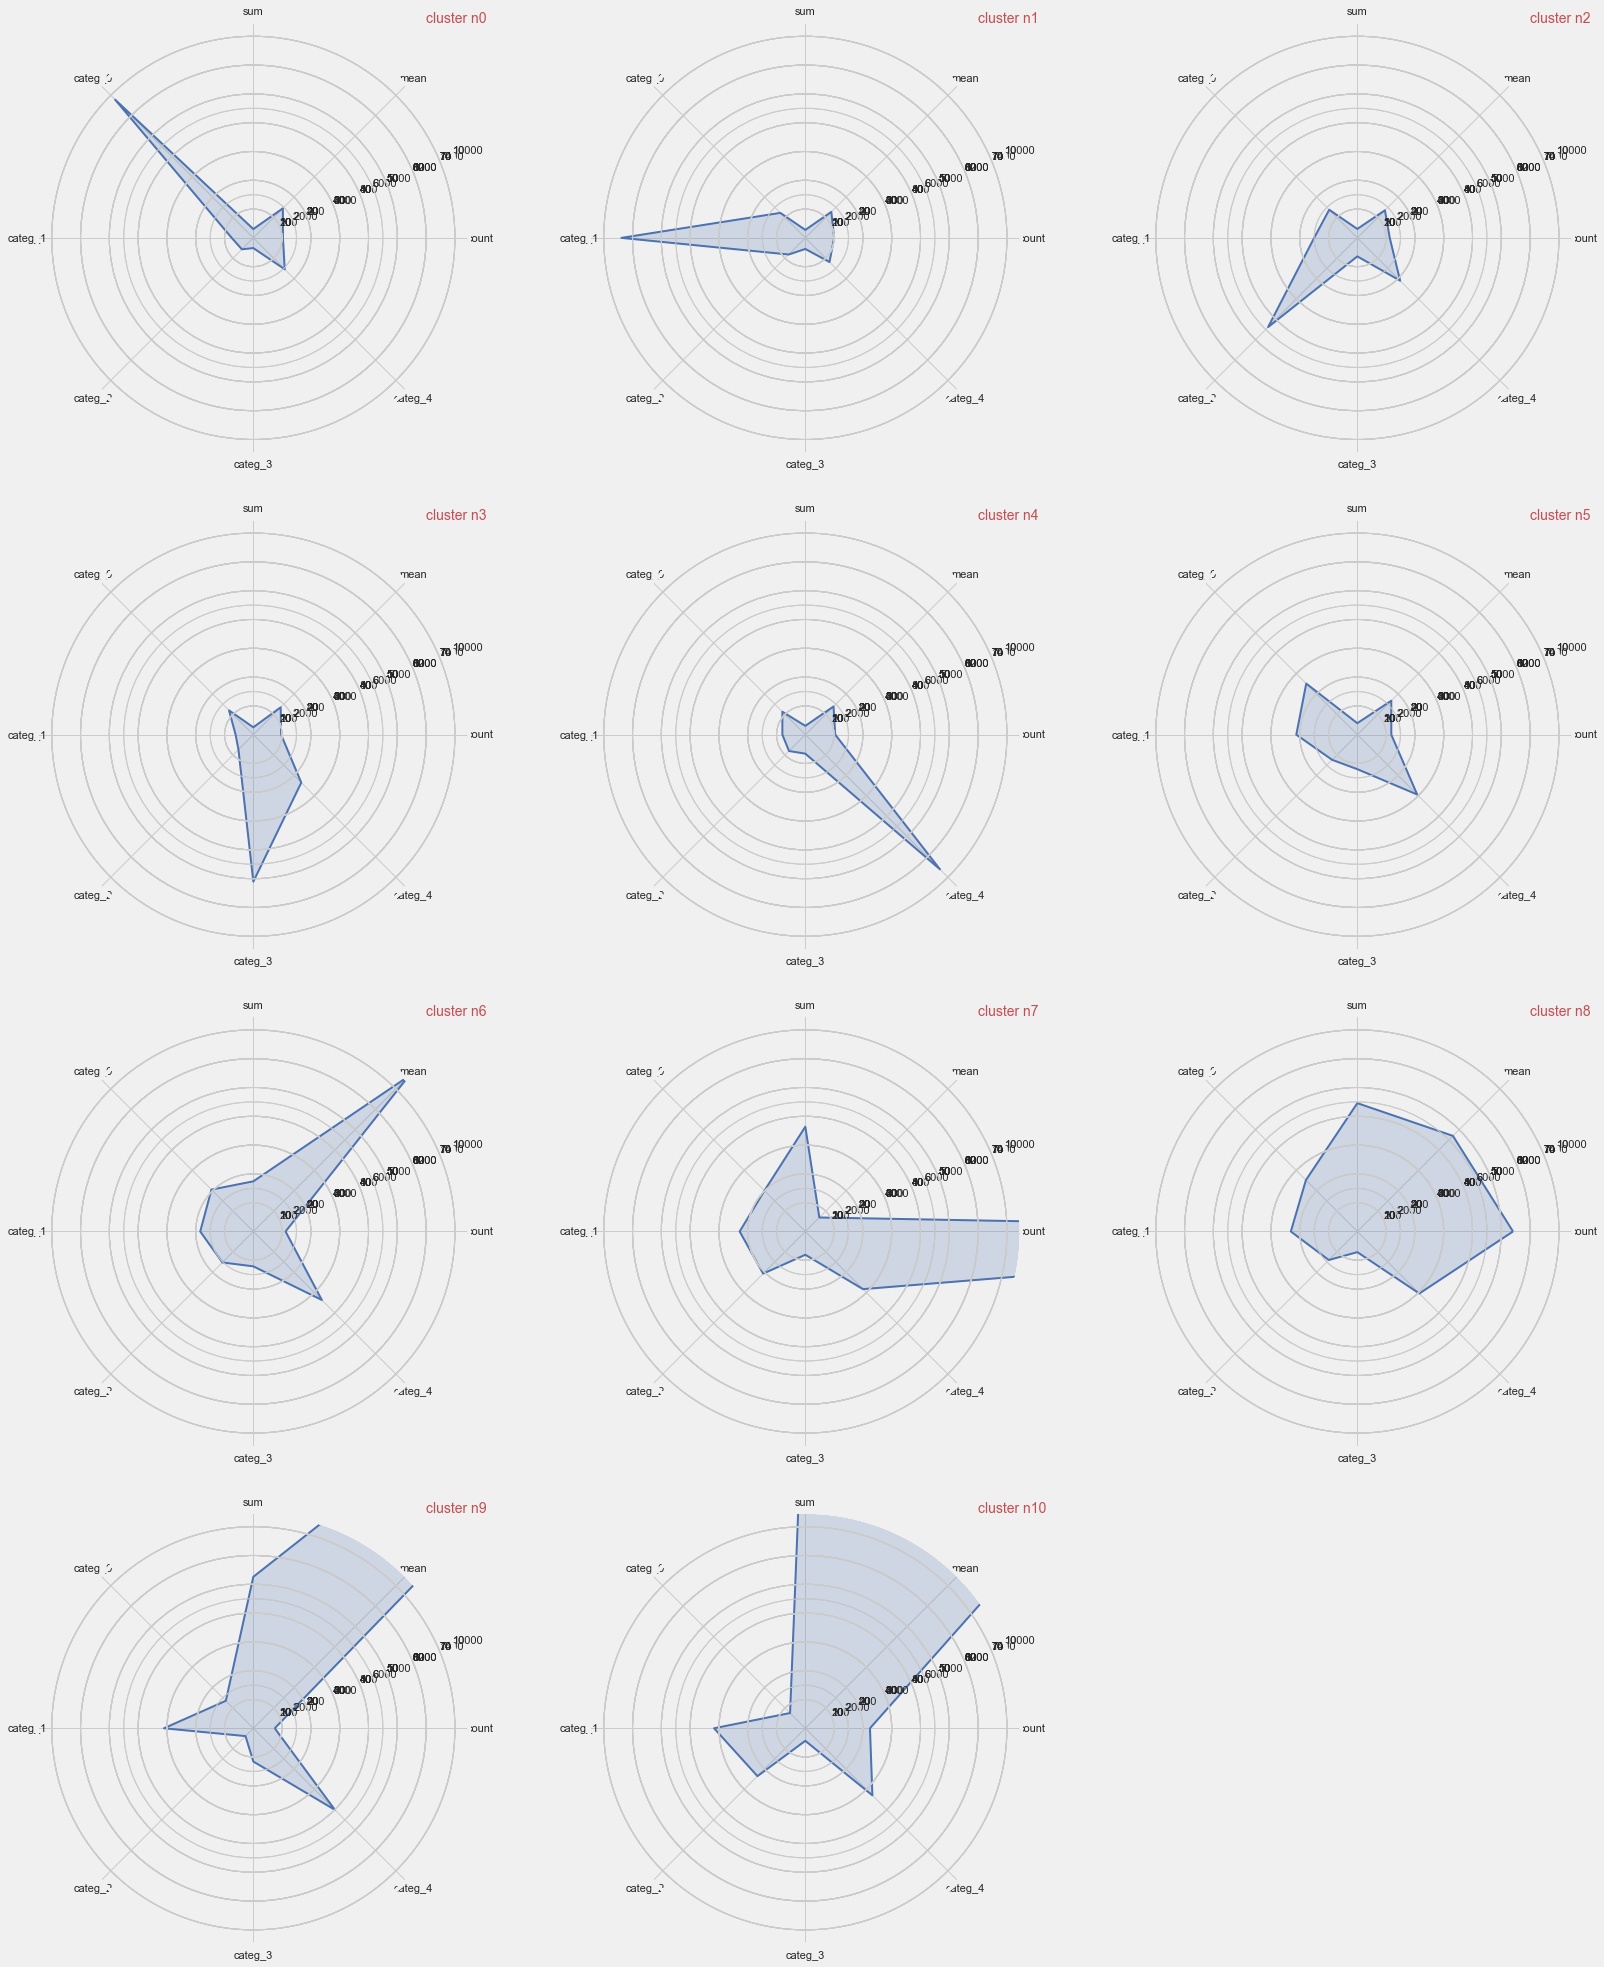

In [80]:
fig = plt.figure(figsize=(20, 18))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters
i_cols = 3
i_rows = n_groups // i_cols
size_x, size_y = (1 / i_cols), (1 / i_rows)

for ind in range(n_clusters):
    ix = ind % 3
    iy = i_rows - ind // 3
    pos_x = ix * (size_x + 0.05)
    pos_y = iy * (size_y + 0.05)
    location = [pos_x, pos_y]
    sizes = [size_x, size_y]
    #______________
    data = np.array(merged_df.loc[index[ind], attributes])
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color='b', linewidth=2.0)
    radar.fill(data, alpha=0.2, color='b')
    radar.title(title='cluster n{}'.format(index[ind]), color='r')
    ind += 1

It can be seen, for example, that the first 5 clusters correspond to a strong preponderance of purchases in a particular category of products. Other clusters will differ from basket averages `mean`, the total sum spent by the clients `sum` or the total number of visits made `count`.

## 5. Classification of customers

In this part, the objective will be to adjust a classifier that will classify consumers in the different client categories that were established in the previous section. The objective is to make this classification possible at the first visit. To fulfill this objective, I will test several classifiers implemented in `scikit-learn`. First, in order to simplify their use, I define a class that allows to interface several of the functionalities common to these different classifiers: 

In [81]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)

    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)

    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print(f'Precision: {100*metrics.accuracy_score(Y, self.predictions):.2f} %')


Since the goal is to define the class to which a client belongs and this, as soon as its first visit, I only keep the variables that describe the content of the basket, and do not take into account the variables related to the frequency of visits or variations of the basket price over time:

In [82]:
col = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[col]
Y = selected_customers['cluster']

Finally, I split the dataset in train and test sets:

In [83]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size=0.8)

### 5.1 Support Vector Machine Classifier (SVC)

The first classifier I use is the SVC classifier. In order to use it, I create an instance of the `Class_Fit` class and then call` grid_search()`. When calling this method, I provide as parameters:
- the hyperparameters for which I will seek an optimal value
- the number of folds to be used for cross-validation

In [84]:
svc = Class_Fit(clf=svm.LinearSVC)
svc.grid_search(parameters=[{'C': np.logspace(-2, 2, 10)}], Kfold=5)

Once this instance is created, I adjust the classifier to the training data:

In [85]:
svc.grid_fit(X=X_train, Y=Y_train)

then I can test the quality of the prediction with respect to the test data:

In [86]:
svc.grid_predict(X_test, Y_test)

Precision: 86.15 %


#### 5.1.1 Confusion matrix

The accuracy of the results seems to be correct. Nevertheless, let us remember that when the different classes were defined, there was an imbalance in size between the classes obtained. In particular, one class contains around 40% of the clients. It is therefore interesting to look at how the predictions and real values compare to the breasts of the different classes. This is the subject of the confusion matrices and to represent them, I use the code of the [sklearn documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html):

In [87]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

from which I create the following representation:

Confusion matrix, without normalization


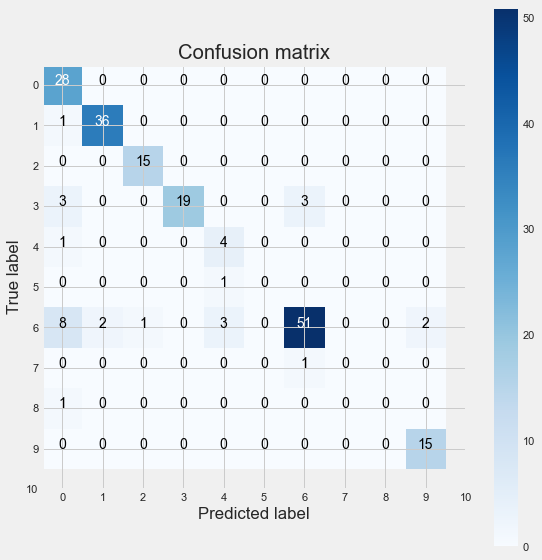

In [88]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions)
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

#### 5.1.2 Learning curve

A typical way to test the quality of a fit is to draw a learning curve. In particular, this type of curves allow to detect possible drawbacks in the model, linked for example to over- or under-fitting. This also shows to which extent the mode could benefit from a larger data sample. In order to draw this curve, I use the [scikit-learn documentation code again](http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-self-examples-model-selection-pad-learning-curve-py)

In [89]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

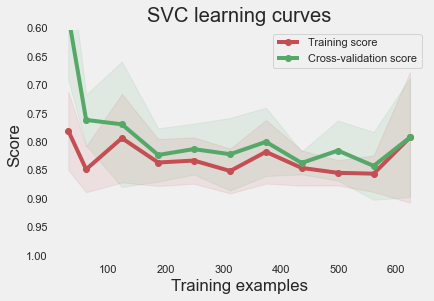

In [90]:
g = plot_learning_curve(svc.grid.best_estimator_, "SVC learning curves", X_train, Y_train, ylim=[1.01, 0.6], cv=5,  train_sizes=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

On this curve, we can see that the train and cross-validation curves converge towards the same limit when the sample size increases. This is typical of modeling with low variance and proves that the model does not suffer from overfitting. Also, we can see that the accuracy of the training curve is correct which is synonymous of a low bias. Hence the model does not underfit the data.

### 5.2 Logistic Regression

I now consider the logistic regression classifier. As before, I create an instance of the `Class_Fit` class, adjust the model on the training data and see how the predictions compare to the real values:

In [91]:
lr = Class_Fit(clf=linear_model.LogisticRegression)
lr.grid_search(parameters=[{'C': np.logspace(-2,2,20)}], Kfold=5)
lr.grid_fit(X=X_train, Y=Y_train)
lr.grid_predict(X_test, Y_test)

Precision: 90.77 %


Then, I plot the learning curve to have a feeling of the quality of the model:

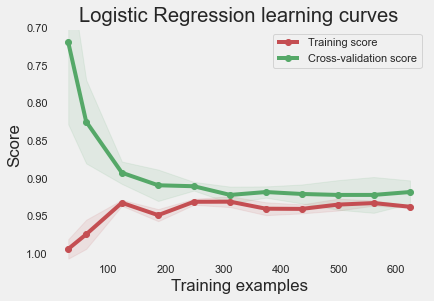

In [92]:
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train, ylim=[1.01, 0.7], cv=5, train_sizes=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.3 k-Nearest Neighbors

In [93]:
knn = Class_Fit(clf=neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold=5)
knn.grid_fit(X=X_train, Y=Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 76.41 %


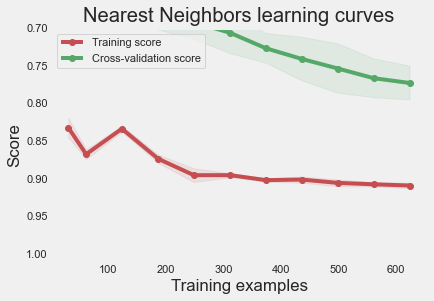

In [94]:
g = plot_learning_curve(knn.grid.best_estimator_, 'Nearest Neighbors learning curves', X_train, Y_train, ylim=[1.01, 0.7], cv=5, train_sizes=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.4 Decision Tree

In [95]:
tr = Class_Fit(clf=tree.DecisionTreeClassifier)
tr.grid_search(parameters=[{'criterion': ['entropy', 'gini'], 'max_features': ['sqrt', 'log2']}], Kfold=5)
tr.grid_fit(X=X_train, Y=Y_train)
tr.grid_predict(X_test, Y_test)

Precision: 86.67 %


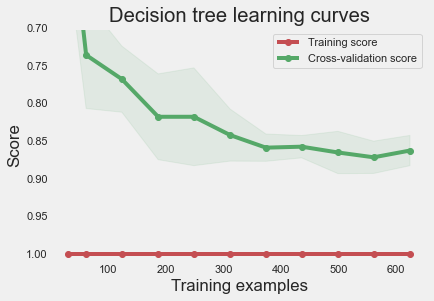

In [96]:
g = plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train, ylim=[1.01, 0.7], cv=5, train_sizes=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.5 Random Forest

In [97]:
rf = Class_Fit(clf=ensemble.RandomForestClassifier)
param_grid = {'criterion': ['entropy', 'gini'], 'n_estimators': [20, 40, 60, 80, 100], 'max_features': ['sqrt', 'log2']}
rf.grid_search(parameters=param_grid, Kfold=5)
rf.grid_fit(X=X_train, Y=Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 91.79 %


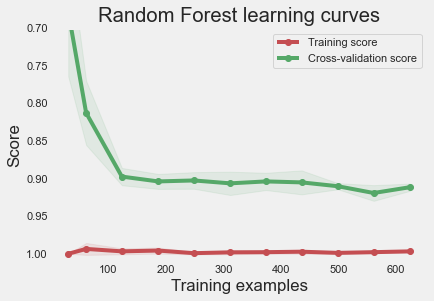

In [98]:
g = plot_learning_curve(rf.grid.best_estimator_, 'Random Forest learning curves', X_train, Y_train, ylim=[1.01, 0.7], cv=5, train_sizes=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.6 AdaBoost Classifier

In [99]:
ada = Class_Fit(clf=AdaBoostClassifier)
param_grid = {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters=param_grid, Kfold=5)
ada.grid_fit(X=X_train, Y=Y_train)
ada.grid_predict(X_test, Y_test)

Precision: 47.18 %


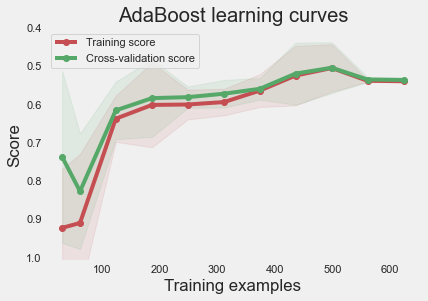

In [100]:
g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost learning curves", X_train, Y_train, ylim=[1.01, 0.4], cv=5, train_sizes=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.7 Gradient Boosting Classifier

In [101]:
gb = Class_Fit(clf=ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters=param_grid, Kfold=5)
gb.grid_fit(X=X_train, Y=Y_train)
gb.grid_predict(X_test, Y_test)

Precision: 91.28 %


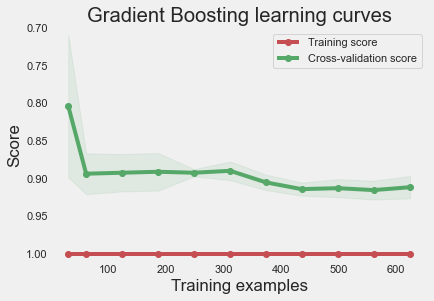

In [102]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train, ylim=[1.01, 0.7], cv=5, train_sizes=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.8 Let's vote !

Finally, the results of the different classifiers presented in the previous sections can be combined to improve the classification model. This can be achieved by selecting the customer category as the one indicated by the majority of classifiers. To do this, I use the `VotingClassifier` method of the `sklearn` package. As a first step, I adjust the parameters of the various classifiers using the *best* parameters previously found:

In [103]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

Then, I define a classifier that merges the results of the various classifiers:

In [104]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best), ('knn', knn_best)], voting='soft')

and train it:

In [105]:
votingC = votingC.fit(X_train, Y_train)

Finally, we can create a prediction for this model:

In [106]:
predictions = votingC.predict(X_test)
print(f'Precision: {100*metrics.accuracy_score(Y_test, predictions):.2f} % ')

Precision: 90.77 % 


Note that when defining the `votingC` classifier, I only used a sub-sample of the whole set of classifiers defined above and only retained the *Random Forest*, the *k-Nearest Neighbors* and the *Gradient Boosting* classifiers. In practice, this choice has been done with respect to the performance of the classification carried out in the next section.

## 6. Testing predictions

In the previous section, a few classifiers were trained in order to categorize customers. Until that point, the whole analysis was based on the data of the first 10 months. In this section, I test the model  the last two months of the dataset, that has been stored in the `set_test` dataframe:

In [107]:
basket_price = set_test.copy(deep=True)

In a first step, I regroup reformattes these data according to the same procedure as used on the training set. However, I am correcting the data to take into account the difference in time between the two datasets and weights the variables `count` and `sum` to obtain an equivalence with the training set:

In [108]:
transactions_per_user = basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count', 'min', 'max', 'mean', 'sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() / transactions_per_user['sum']*100

transactions_per_user.reset_index(drop=False, inplace=True)

display(transactions_per_user.sort_values('CustomerID', ascending=True)[:10])

CustomerID  count      min      max         mean      sum    categ_0  \
0      12347      6   224.82  1294.32   599.701667  3598.21  22.602905   
1      12348      3   227.44   367.00   301.480000   904.44   0.000000   
2      12349      1  1757.55  1757.55  1757.550000  1757.55  12.245455   
3      12350      1   334.40   334.40   334.400000   334.40  27.900718   
4      12352      7   144.35   840.30   340.815714  2385.71   4.071325   
5      12353      1    89.00    89.00    89.000000    89.00  19.887640   
6      12354      1  1079.40  1079.40  1079.400000  1079.40  10.825459   
7      12355      1   459.40   459.40   459.400000   459.40  11.558555   
8      12356      3    58.35  2271.62   937.143333  2811.43  12.587900   
9      12357      1  6207.67  6207.67  6207.670000  6207.67  14.684737   

     categ_1    categ_2    categ_3    categ_4  
0  27.231318   5.650032  12.809703  31.706043  
1   0.000000   0.000000  22.604042  77.395958  
2  10.713778  20.389178   4.513101  52.138488  
3   0.000000   0.000000  11.692584  60.406699  
4  14.601523  14.691643   1.299404  65.336105  
5   0.000000  22.359551   0.000000  57.752809  
6  19.700760  16.235872  14.950899  38.287011  
7  25.272094   0.000000   0.000000  63.169351  
8   7.256094  13.184749  14.147605  52.823652  
9  28.350089  25.189000   5.089832  26.686341

Then, I convert the dataframe into a matrix and retain only variables that define the category to which consumers belong. At this level, I recall the method of normalization that had been used on the training set:

In [109]:
list_cols = ['count', 'min', 'max', 'mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
#_____________________________________________________________
matrix_test = transactions_per_user[list_cols].to_numpy()
scaled_test_matrix = scaler.transform(matrix_test)

Each line in this matrix contains a consumer's buying habits. At this stage, it is a question of using these habits in order to define the category to which the consumer belongs. These categories have been established in **Section 4**. At this stage, it is important to bear in mind that this step does not correspond to the classification stage itself. Here, we prepare the test data by defining the category to which the customers belong. However, this definition uses data obtained over a period of 2 months (via the variables `count`, `min`, `max` and `sum`). The classifier defined in **Section 5** uses a more restricted set of variables that will be defined from the first purchase of a client.

Here it is a question of using the available data over a period of two months and using this data to define the category to which the customers belong. Then, the classifier can be tested by comparing its predictions with these categories. In order to define the category to which the clients belong, I recall the instance of the `kmeans` method used in **Section 4**. The` predict` method of this instance calculates the distance of the consumers from the centroids of the 11 client classes and the smallest distance will define the belonging to the different categories:

In [110]:
Y = kmeans.predict(scaled_test_matrix)

Finally, in order to prepare the execution of the classifier, it is sufficient to select the variables on which it acts:

In [111]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
X = transactions_per_user[columns]

It remains only to examine the predictions of the different classifiers that have been trained in section 5:

In [112]:
classifiers = [
    (svc, 'Support Vector Machine'),
    (lr, 'Logostic Regression'),
    (knn, 'k-Nearest Neighbors'),
    (tr, 'Decision Tree'),
    (rf, 'Random Forest'),
    (gb, 'Gradient Boosting')
]
#______________________________
for clf, label in classifiers:
    print(30*'_', f'\n{label}')
    clf.grid_predict(X, Y)

______________________________ 
Support Vector Machine
Precision: 76.07 %
______________________________ 
Logostic Regression
Precision: 80.20 %
______________________________ 
k-Nearest Neighbors
Precision: 66.02 %
______________________________ 
Decision Tree
Precision: 77.12 %
______________________________ 
Random Forest
Precision: 80.51 %
______________________________ 
Gradient Boosting
Precision: 79.86 %


Finally, as anticipated in **Section 5.8**, it is possible to improve the quality of the classifier by combining their respective predictions. At this level, I chose to mix `Random Forest`, `Gradient Boosting` and `k-Nearest Neighbors` predictions because this leads to a slight improvement in predictions:

In [113]:
predictions = votingC.predict(X)
print(f'Precision: {100*metrics.accuracy_score(Y, predictions):.2f} % ')

Precision: 80.36 % 


## 7. RFM model

### 7.1 Transformation to RFM model

#### 7.1.1 Grouping RFM

In [114]:
df_rfm = df_cleaned.copy(deep=True)
display(df_rfm[:10])

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
5    536365     22752         SET 7 BABUSHKA NESTING BOXES         2   
6    536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER         6   
7    536366     22633               HAND WARMER UNION JACK         6   
8    536366     22632            HAND WARMER RED POLKA DOT         6   
9    536367     84879        ASSORTED COLOUR BIRD ORNAMENT        32   

          InvoiceDate  UnitPrice CustomerID         Country  QuantityCanceled  \
0 2010-12-01 08:26:00       2.55      17850  United Kingdom                 0   
1 2010-12-01 08:26:00       3.39      17850  United Kingdom                 0   
2 2010-12-01 08:26:00       2.75      17850  United Kingdom                 0   
3 2010-12-01 08:26:00       3.39      17850  United Kingdom                 0   
4 2010-12-01 08:26:00       3.39      17850  United Kingdom                 0   
5 2010-12-01 08:26:00       7.65      17850  United Kingdom                 0   
6 2010-12-01 08:26:00       4.25      17850  United Kingdom                 0   
7 2010-12-01 08:28:00       1.85      17850  United Kingdom                 0   
8 2010-12-01 08:28:00       1.85      17850  United Kingdom                 0   
9 2010-12-01 08:34:00       1.69      13047  United Kingdom                 0   

   TotalPrice  categ_product  categ_0  categ_1  categ_2  categ_3  categ_4  
0       15.30              0     15.3     0.00      0.0      0.0     0.00  
1       20.34              1      0.0    20.34      0.0      0.0     0.00  
2       22.00              1      0.0    22.00      0.0      0.0     0.00  
3       20.34              1      0.0    20.34      0.0      0.0     0.00  
4       20.34              1      0.0    20.34      0.0      0.0     0.00  
5       15.30              2      0.0     0.00     15.3      0.0     0.00  
6       25.50              1      0.0    25.50      0.0      0.0     0.00  
7       11.10              0     11.1     0.00      0.0      0.0     0.00  
8       11.10              4      0.0     0.00      0.0      0.0    11.10  
9       54.08              4      0.0     0.00      0.0      0.0    54.08

In [115]:
# The last day of purchase in total is 09 DEC, 2011. To calculate the day periods, let's set one day after the last one,or 10 DEC as a snapshot_date.
# We will cound the diff days with snapshot_date.
snapshot_date = df_rfm['InvoiceDate'].max() + datetime.timedelta(days=1)
display(snapshot_date)

Timestamp('2011-12-10 12:50:00')

In [116]:
df_rfm = df_rfm[df_rfm['TotalPrice'] > 0]
display(df_rfm[:10])

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
5    536365     22752         SET 7 BABUSHKA NESTING BOXES         2   
6    536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER         6   
7    536366     22633               HAND WARMER UNION JACK         6   
8    536366     22632            HAND WARMER RED POLKA DOT         6   
9    536367     84879        ASSORTED COLOUR BIRD ORNAMENT        32   

          InvoiceDate  UnitPrice CustomerID         Country  QuantityCanceled  \
0 2010-12-01 08:26:00       2.55      17850  United Kingdom                 0   
1 2010-12-01 08:26:00       3.39      17850  United Kingdom                 0   
2 2010-12-01 08:26:00       2.75      17850  United Kingdom                 0   
3 2010-12-01 08:26:00       3.39      17850  United Kingdom                 0   
4 2010-12-01 08:26:00       3.39      17850  United Kingdom                 0   
5 2010-12-01 08:26:00       7.65      17850  United Kingdom                 0   
6 2010-12-01 08:26:00       4.25      17850  United Kingdom                 0   
7 2010-12-01 08:28:00       1.85      17850  United Kingdom                 0   
8 2010-12-01 08:28:00       1.85      17850  United Kingdom                 0   
9 2010-12-01 08:34:00       1.69      13047  United Kingdom                 0   

   TotalPrice  categ_product  categ_0  categ_1  categ_2  categ_3  categ_4  
0       15.30              0     15.3     0.00      0.0      0.0     0.00  
1       20.34              1      0.0    20.34      0.0      0.0     0.00  
2       22.00              1      0.0    22.00      0.0      0.0     0.00  
3       20.34              1      0.0    20.34      0.0      0.0     0.00  
4       20.34              1      0.0    20.34      0.0      0.0     0.00  
5       15.30              2      0.0     0.00     15.3      0.0     0.00  
6       25.50              1      0.0    25.50      0.0      0.0     0.00  
7       11.10              0     11.1     0.00      0.0      0.0     0.00  
8       11.10              4      0.0     0.00      0.0      0.0    11.10  
9       54.08              4      0.0     0.00      0.0      0.0    54.08

In [117]:
rfm = df_rfm.groupby(by='CustomerID', as_index=False).agg(
    {
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'InvoiceNo': 'count',
        'TotalPrice': 'sum'
    }
)

display(rfm[:10])

CustomerID  InvoiceDate  InvoiceNo  TotalPrice
0      12347            2        182     4310.00
1      12348           75         31     1797.24
2      12349           19         73     1757.55
3      12350          310         17      334.40
4      12352           36         78     2385.71
5      12353          204          4       89.00
6      12354          232         58     1079.40
7      12355          214         13      459.40
8      12356           23         59     2811.43
9      12357           33        131     6207.67

In [118]:
rfm.rename(
    columns={
        'InvoiceDate': 'Recency',
        'InvoiceNo': 'Frequency',
        'TotalPrice': 'Monetary'
    },
    inplace=True
)
display(rfm[:10])

CustomerID  Recency  Frequency  Monetary
0      12347        2        182   4310.00
1      12348       75         31   1797.24
2      12349       19         73   1757.55
3      12350      310         17    334.40
4      12352       36         78   2385.71
5      12353      204          4     89.00
6      12354      232         58   1079.40
7      12355      214         13    459.40
8      12356       23         59   2811.43
9      12357       33        131   6207.67

In [119]:
RFM = ['Recency', 'Frequency', 'Monetary']
R_m, F_m, M_m = rfm[RFM].mean()
R_s, F_s, M_s = rfm[RFM].std()
rfm = rfm[
    (rfm.Recency < R_m + 3 * R_s)
    & (rfm.Frequency < F_m + 3 * F_s)
    & (rfm.Monetary < M_m + 3 * M_s)
]

display(rfm[:10])

CustomerID  Recency  Frequency  Monetary
0      12347        2        182   4310.00
1      12348       75         31   1797.24
2      12349       19         73   1757.55
3      12350      310         17    334.40
4      12352       36         78   2385.71
5      12353      204          4     89.00
6      12354      232         58   1079.40
7      12355      214         13    459.40
8      12356       23         59   2811.43
9      12357       33        131   6207.67

#### 7.1.2 Plot cruves about RFM model

In [120]:
rfm.sort_values('Recency', ascending=False, inplace=True)
#______________
num = 4000
y1 = rfm.Recency[:num]

temp_list = rfm.Recency.cumsum()[:num]
temp_sum = rfm.Recency.cumsum()[:num].max()
y2 = temp_list / temp_sum

x = np.arange(1, rfm.Recency[:num].shape[0]+1)
#______________
trace1 = go.Bar(
    x=x,
    y=y1,
    xaxis='x',
    yaxis='y1',
    name='Recency'
)
trace2 = go.Scatter(
    x=x,
    y=y2,
    mode="lines",
    xaxis='x',
    yaxis='y2',
    name='Recency Cumulative Percentage'
)
layout = go.Layout(
    yaxis2=dict(anchor='x', overlaying='y', side='right'),
    height=1000
)
#______________
data = [trace1, trace2]
bar = go.Figure(data=data, layout=layout)
iplot(bar, validate=False)

In [121]:
box = [0, 10, 20, 50, 100, 200, 500]
pd.cut(rfm.Recency, box).value_counts()

(20, 50]      935
(50, 100]     817
(200, 500]    744
(0, 10]       684
(100, 200]    614
(10, 20]      485
Name: Recency, dtype: int64

In [122]:
rfm.sort_values('Frequency', ascending=False, inplace=True)
#______________
num = 4000
y1 = rfm.Frequency[:num]

temp_list = rfm.Frequency.cumsum()[:num]
temp_sum = rfm.Frequency.cumsum()[:num].max()
y2 = temp_list / temp_sum

x = np.arange(1, rfm.Frequency[:num].shape[0]+1)
#______________
trace1 = go.Bar(
    x=x,
    y=y1,
    xaxis='x',
    yaxis='y1',
    name='Frequency'
)
trace2 = go.Scatter(
    x=x,
    y=y2,
    mode="lines",
    xaxis='x',
    yaxis='y2',
    name='Frequency Cumulative Percentage'
)
layout = go.Layout(
    yaxis2=dict(anchor='x', overlaying='y', side='right'),
    height=1000
)
#______________
data = [trace1, trace2]
bar = go.Figure(data=data, layout=layout)
iplot(bar, validate=False)

In [123]:
box = [0, 20, 50, 100, 200, 500, 1000]
pd.cut(rfm.Frequency, box).value_counts()

(0, 20]        1286
(20, 50]       1160
(50, 100]       823
(100, 200]      614
(200, 500]      353
(500, 1000]      43
Name: Frequency, dtype: int64

In [124]:
rfm.sort_values('Monetary', ascending=False, inplace=True)
#______________
num = 4000
y1 = rfm.Monetary[:num]

temp_list = rfm.Monetary.cumsum()[:num]
temp_sum = rfm.Monetary.cumsum()[:num].max()
y2 = temp_list / temp_sum

x = np.arange(1, rfm.Monetary[:num].shape[0]+1)
#______________
trace1 = go.Bar(
    x=x,
    y=y1,
    xaxis='x',
    yaxis='y1',
    name='Monetary'
)
trace2 = go.Scatter(
    x=x,
    y=y2,
    mode="lines",
    xaxis='x',
    yaxis='y2',
    name='Monetary Cumulative Percentage'
)
layout = go.Layout(
    yaxis2=dict(anchor='x', overlaying='y', side='right'),
    height=1000
)
#______________
data = [trace1, trace2]
bar = go.Figure(data=data, layout=layout)
iplot(bar, validate=False)

In [125]:
box = [0, 200, 500, 1000, 2000, 5000, 10000]
pd.cut(rfm.Monetary, box).value_counts()

(200, 500]       1121
(500, 1000]       910
(1000, 2000]      758
(0, 200]          663
(2000, 5000]      604
(5000, 10000]     158
Name: Monetary, dtype: int64

We can see the long-tailed distributions

### 7.2 Establish a user behavior scoring mechanism

Recency, Frequency, Monetary higher, scoring higher

In [126]:
# Building RFM segments
r_labels = range(4, -1, -1)
f_labels = range(0, 5)
m_labels = range(0, 5)

In [127]:
r_quartiles = pd.qcut(rfm['Recency'], q=5, labels=r_labels)
f_quartiles = pd.qcut(rfm['Frequency'], q=5, labels=f_labels)
m_quartiles = pd.qcut(rfm['Monetary'], q=5, labels=m_labels)
rfm = rfm.assign(R=r_quartiles, F=f_quartiles, M=m_quartiles)
display(rfm[:10])

CustomerID  Recency  Frequency  Monetary  R  F  M
1706      14680       25        255  27107.30  3  4  4
4011      17857        4         53  26763.34  4  2  4
2913      16333        8         45  26626.80  4  2  4
1052      13777        1        197  25792.88  4  4  4
2495      15749      235          6  24850.90  0  0  4
2830      16210        2        123  21086.30  4  4  4
326       12753       23        196  21024.78  3  4  4
3666      17381        9        109  20272.43  4  3  4
3884      17675        1        699  20105.60  4  4  4
320       12744       52        221  19226.22  2  4  4

In [128]:
# Build RFM Segment and RFM Score
def add_rfm(x):
    return str(x['R']) + str(x['F']) + str(x['M'])

rfm['RFM_Segment'] = rfm.apply(add_rfm, axis=1)
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
display(rfm[:10])

CustomerID  Recency  Frequency  Monetary  R  F  M RFM_Segment  RFM_Score
1706      14680       25        255  27107.30  3  4  4         344         11
4011      17857        4         53  26763.34  4  2  4         424         10
2913      16333        8         45  26626.80  4  2  4         424         10
1052      13777        1        197  25792.88  4  4  4         444         12
2495      15749      235          6  24850.90  0  0  4         004          4
2830      16210        2        123  21086.30  4  4  4         444         12
326       12753       23        196  21024.78  3  4  4         344         11
3666      17381        9        109  20272.43  4  3  4         434         11
3884      17675        1        699  20105.60  4  4  4         444         12
320       12744       52        221  19226.22  2  4  4         244         10

In [129]:
display(rfm[rfm['RFM_Segment'] == '000'][:10])

CustomerID  Recency  Frequency  Monetary  R  F  M RFM_Segment  RFM_Score
2987      16427      263          9    241.06  0  0  0         000          0
3224      16756      215         13    239.40  0  0  0         000          0
3446      17060      266          5    234.24  0  0  0         000          0
315       12736      333          4    234.00  0  0  0         000          0
1058      13786      367          7    230.40  0  0  0         000          0
1005      13712      247         10    228.84  0  0  0         000          0
547       13070      192          9    228.80  0  0  0         000          0
3547      17212      253          4    226.85  0  0  0         000          0
261       12672      330         10    225.90  0  0  0         000          0
43        12402      323         11    225.60  0  0  0         000          0

In [130]:
display(rfm.groupby('RFM_Score').agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary': 'mean'}).round(1))

Recency  Frequency  Monetary
RFM_Score                              
0            278.0        6.5     132.6
1            209.8       11.1     193.3
2            186.4       16.3     283.0
3            125.4       19.3     354.7
4            103.9       25.5     529.6
5             91.8       35.8     613.5
6             71.1       44.3     841.9
7             59.8       60.9    1085.8
8             44.6       76.9    1396.5
9             35.4      107.9    1751.8
10            24.8      135.2    2555.7
11            15.8      208.6    3818.3
12             5.9      288.9    5456.9

Use the RFM score to divide users into important users/general users/potential users

### 7.3 Creation og customer categories

In [131]:
def segments (df) :
    if df['RFM_Score'] > 9:
        return 'Gold'
    elif (df['RFM_Score'] > 5):
        return 'Sliver'
    else :
        return 'Bronze'

rfm['General_Segment'] = rfm.apply(segments, axis = 1)
display(rfm.groupby('General_Segment').agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary': 'mean'}).round(1))

Recency  Frequency  Monetary
General_Segment                              
Bronze             157.1       20.2     371.9
Gold                15.8      208.5    3898.6
Sliver              53.6       70.9    1245.8

In [132]:
# Logarithmic transformation
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis=1)

In [133]:
colors = ['#393E46', '#2BCDC1', '#F66095']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot([rfm_log[c] for c in rfm_log.columns], RFM, bin_size=0.3, curve_type='kde', colors=colors)

# Add title
fig.update_layout(title_text='RFM model')
fig.show()

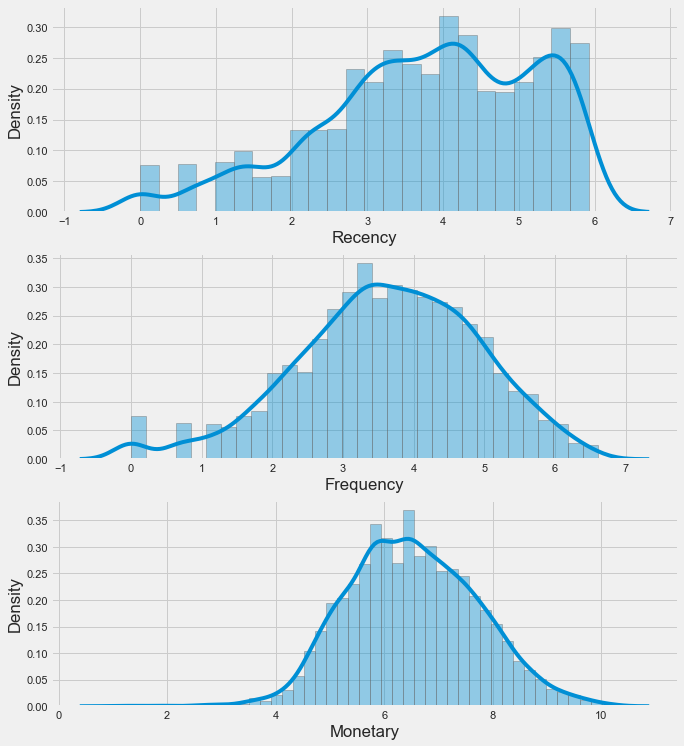

In [134]:
# plot the distribution of RFM values
f,ax = plt.subplots(figsize=(10,12))
plt.subplot(3, 1, 1);sns.distplot(rfm_log.Recency,label='Recency')
plt.subplot(3, 1, 2);sns.distplot(rfm_log.Frequency,label='Frequency')
plt.subplot(3, 1, 3);sns.distplot(rfm_log.Monetary,label='Monetary')
plt.show()

In [135]:
# Normalize the variables with StandardScaler
scaler = StandardScaler()
scaler.fit(rfm_log)
# Store it separately for clustering
rfm_normalized = scaler.transform(rfm_log)

#### 7.3.1 Elbow image
- Plot the number of clusters against within-cluster sum-of-squared-errors (SSE) - sum of squared distances from every data point to their cluster center
- Identify an "elbow" in the plot
- Elbow - a point representing an "optimal" number of clusters

In [136]:
inertias = []
n_clusters_list = [i for i in range(1, 15)]
for n_clusters in n_clusters_list:
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=30)
    kmeans.fit(rfm_normalized)
    inertias.append(kmeans.inertia_)

In [137]:
trace = go.Scatter(
     x=n_clusters_list,
     y=inertias,
     xaxis='x',
     yaxis='y',
     mode='lines+markers',
)
data = [trace]

iplot(data)

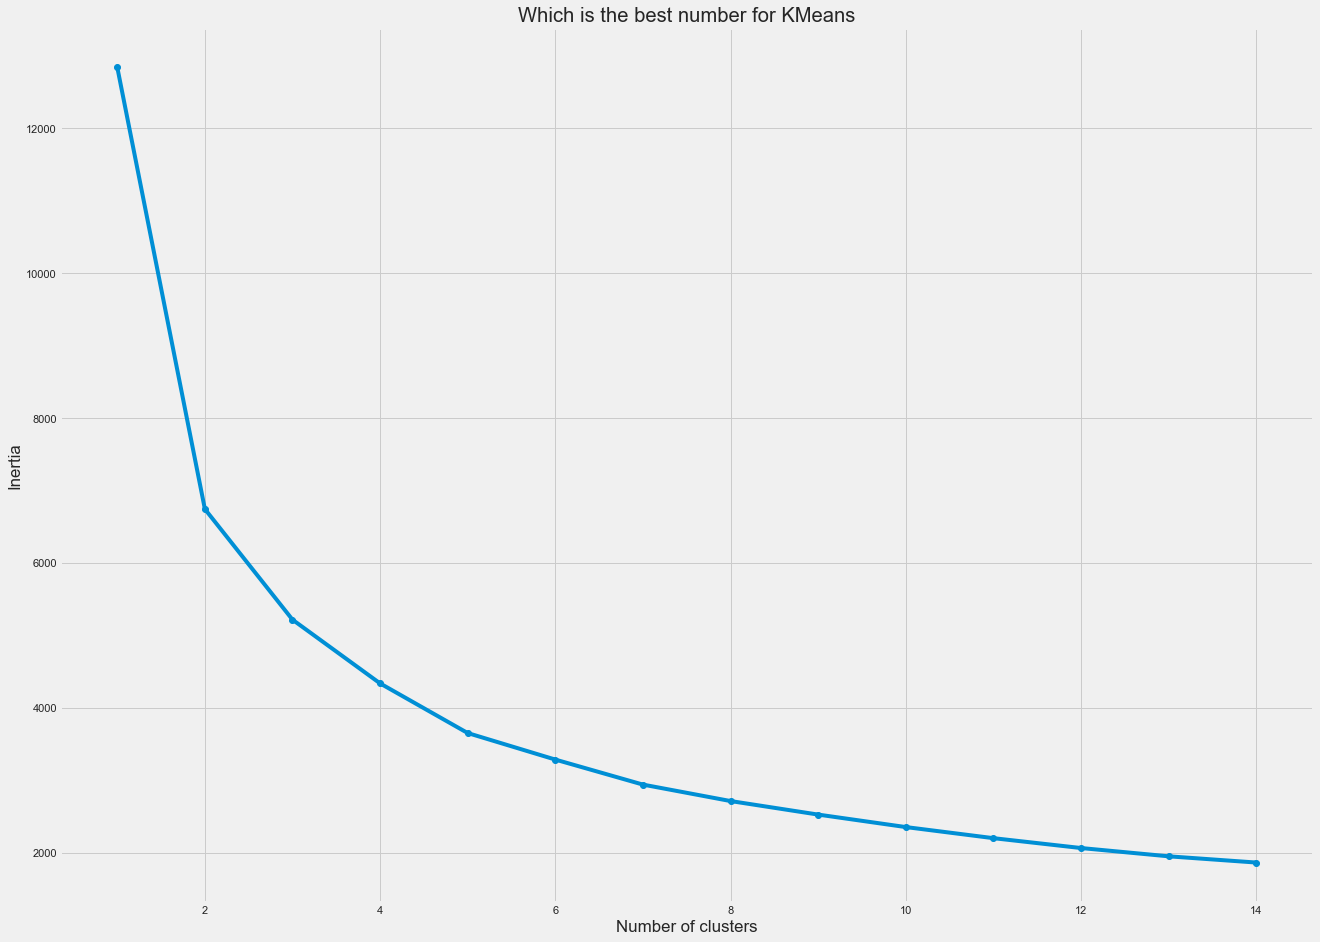

In [138]:
# plot n_clusters vs inertias
f, ax = plt.subplots(figsize=(20,15))
plt.plot(n_clusters_list, inertias, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Which is the best number for KMeans')
plt.show()

#### 7.3.2 Silhouette score

In [139]:
for n_clusters in range(2, 15):
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=30)
    kmeans.fit(rfm_normalized)
    clusters = kmeans.predict(rfm_normalized)
    silhouette_avg = silhouette_score(rfm_normalized, clusters)
    print(f'For n_clusters = {n_clusters}, The average silhouette_score is : {silhouette_avg:.4f}')

For n_clusters = 2, The average silhouette_score is : 0.3941
For n_clusters = 3, The average silhouette_score is : 0.2980
For n_clusters = 4, The average silhouette_score is : 0.3008
For n_clusters = 5, The average silhouette_score is : 0.2808
For n_clusters = 6, The average silhouette_score is : 0.2756
For n_clusters = 7, The average silhouette_score is : 0.2685
For n_clusters = 8, The average silhouette_score is : 0.2585
For n_clusters = 9, The average silhouette_score is : 0.2640
For n_clusters = 10, The average silhouette_score is : 0.2723
For n_clusters = 11, The average silhouette_score is : 0.2636
For n_clusters = 12, The average silhouette_score is : 0.2594
For n_clusters = 13, The average silhouette_score is : 0.2625
For n_clusters = 14, The average silhouette_score is : 0.2545


In [140]:
n_clusters = 3
kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=30)
kmeans.fit(rfm_normalized)
clusters = kmeans.predict(rfm_normalized)

pd.Series(clusters).value_counts()

2    1809
0    1369
1    1101
dtype: int64

In [141]:
cluster_labels = kmeans.labels_
rfm = rfm.assign(k_cluster=cluster_labels)

# Calculate average RFM values and sizes for each cluster
rfm.groupby('k_cluster').agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary': 'mean'}).round(1)

Recency  Frequency  Monetary
k_cluster                              
0            174.6       13.2     267.4
1             17.1      189.6    3612.8
2             79.0       56.5     932.9

### 7.4 Comparing users of different levels

In [142]:
rfm_normalized = pd.DataFrame(rfm_normalized, index=rfm_log.index, columns=rfm_log.columns)
rfm_normalized['k_cluster'] = cluster_labels
rfm_normalized['General_Segment'] = rfm['General_Segment']

# Melt the data into a long format so RFM values and metric names are stored in 1 column each
rfm_melt = pd.melt(rfm_normalized, id_vars=['General_Segment', 'k_cluster'], value_vars=['Recency', 'Frequency', 'Monetary'], var_name='Metric', value_name='Value')
display(rfm_melt[:10])

General_Segment  k_cluster   Metric     Value
0            Gold          1  Recency -0.406718
1            Gold          1  Recency -1.701685
2            Gold          1  Recency -1.211883
3            Gold          1  Recency -2.681290
4          Bronze          2  Recency  1.176647
5            Gold          1  Recency -2.191488
6            Gold          1  Recency -0.465638
7            Gold          1  Recency -1.128653
8            Gold          1  Recency -2.681290
9            Gold          1  Recency  0.110799

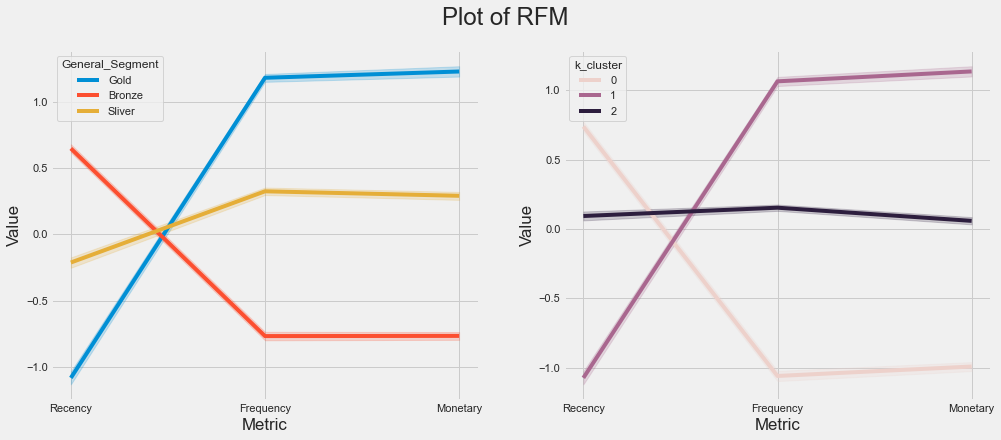

In [143]:
import seaborn as sns
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.lineplot(x='Metric', y='Value', hue='General_Segment', data=rfm_melt, ax=ax1)

# a snake plot with K-Means
sns.lineplot(x='Metric', y='Value', hue='k_cluster', data=rfm_melt, ax=ax2)

plt.suptitle("Plot of RFM", fontsize=24)
plt.show()

In [144]:
# The further a ratio is from 0, the more important that attribute is for a segment relative to the total population
cluster_avg = rfm[['k_cluster', 'Recency', 'Frequency', 'Monetary']].groupby(['k_cluster']).mean()
population_avg = rfm[RFM].mean()
relative_imp = cluster_avg / population_avg - 1
relative_imp.round(1)

Recency  Frequency  Monetary
k_cluster                              
0              0.9       -0.8      -0.8
1             -0.8        1.5       1.6
2             -0.2       -0.3      -0.3

In [145]:
# calculate the proportional gap with total mean
cluster_avg = rfm[['General_Segment', 'Recency', 'Frequency', 'Monetary']].groupby('General_Segment').mean()
# the mean value in total
population_avg = rfm[RFM].mean()
prop_rfm = cluster_avg / population_avg - 1
prop_rfm.round(1)

Recency  Frequency  Monetary
General_Segment                              
Bronze               0.7       -0.7      -0.7
Gold                -0.8        1.7       1.8
Sliver              -0.4       -0.1      -0.1

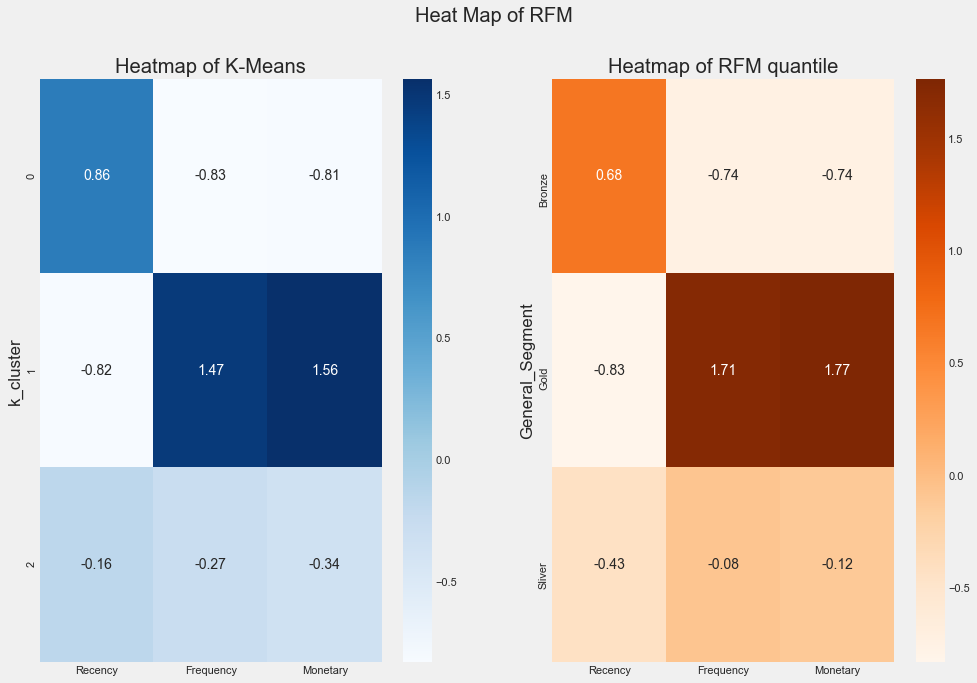

In [146]:
# heatmap with RFM
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
sns.heatmap(data=relative_imp, annot=True, fmt='.2f',cmap='Blues', ax=ax1)
ax1.set(title = "Heatmap of K-Means")

# a snake plot with K-Means
sns.heatmap(prop_rfm, cmap='Oranges', fmt='.2f', annot=True, ax=ax2)
ax2.set(title='Heatmap of RFM quantile')

plt.suptitle("Heat Map of RFM", fontsize=20)

plt.show()

In [147]:
# cov = coefficient of variance
def cov(x):
    return np.std(x)/ np.mean(x)

In [148]:
display(rfm.groupby('General_Segment').agg({'Recency':['mean', 'std', cov], 'Frequency':['mean', 'std', cov], 'Monetary':['mean', 'std', cov]}).round(1))

Recency             Frequency             Monetary          \
                   mean    std  cov      mean    std  cov     mean     std   
General_Segment                                                              
Bronze            157.1  107.6  0.7      20.2   16.3  0.8    371.9   629.8   
Gold               15.8   15.1  1.0     208.5  135.7  0.7   3898.6  3576.1   
Sliver             53.6   54.3  1.0      70.9   50.2  0.7   1245.8  1206.6   

                      
                 cov  
General_Segment       
Bronze           1.7  
Gold             0.9  
Sliver           1.0

In [149]:
display(rfm.groupby('k_cluster').agg({'Recency':['mean', 'std', cov], 'Frequency':['mean', 'std', cov], 'Monetary':['mean', 'std', cov]}).round(1))

Recency             Frequency             Monetary             
             mean    std  cov      mean    std  cov     mean     std  cov
k_cluster                                                                
0           174.6  110.2  0.6      13.2    9.6  0.7    267.4   244.7  0.9
1            17.1   18.4  1.1     189.6  135.5  0.7   3612.8  3457.0  1.0
2            79.0   75.3  1.0      56.5   38.4  0.7    932.9   953.3  1.0

## 8. Conclusion

The work described in this notebook is based on a database providing details on purchases made on an E-commerce platform over a period of one year. Each entry in the dataset describes the purchase of a product, by a particular customer and at a given date. In total, approximately ~4000 clients appear in the database. Given the available information, I decided to develop a classifier that allows to anticipate the type of purchase that a customer will make, as well as the number of visits that he will make during a year, and this from its first visit to the E-commerce site.

The first stage of this work consisted in describing the different products sold by the site, which was the subject of a first classification. There, I grouped the different products into 5 main categories of goods. In a second step, I performed a classification of the customers by analyzing their consumption habits over a period of 10 months. I have classified clients into 11 major categories based on the type of products they usually buy, the number of visits they make and the amount they spent during the 10 months. Once these categories established, I finally trained several classifiers whose objective is to be able to classify consumers in one of these 11 categories and this from their first purchase. For this, the classifier is based on 5 variables which are:
- `mean`: amount of the basket of the current purchase
- `categ_N` with $N \in [0: 4]$: percentage spent in product category with index $N$

Finally, the quality of the predictions of the different classifiers was tested over the last two months of the dataset. The data were then processed in two steps: first, all the data was considered (ober the 2 months) to define the category to which each client belongs, and then, the classifier predictions were compared with this category assignment. I then found that 75% of clients are awarded the right classes.
The performance of the classifier therefore seems correct given the potential shortcomings of the current model. In particular, a bias that has not been dealt with concerns the seasonality of purchases and the fact that purchasing habits will potentially depend on the time of year (for example, Christmas ). In practice, this seasonal effect may cause the categories defined over a 10-month period to be quite different from those extrapolated from the last two months. In order to correct such bias, it would be beneficial to have data that would cover a longer period of time.